In [1]:
from copy import deepcopy
import glob
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt
from collections import defaultdict
import pycircstat as circ
from scipy import stats
import scipy.io as sio
import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from bokeh.io import output_file, show, output_notebook, push_notebook

from cosmos.imaging.cell_sorter import CellSorter
import cosmos.traces.trace_analysis_utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Inspect components

In [2]:
# Get a list of all the out.mat + TTL mat files in the base directory
def get_paths(base_path):
    ttl_paths = []
    file_paths = []
    for root, dirs, files in os.walk(base_path):
        if mouse not in root:
            continue
        if 'old' in root:
            continue
        for file in files:
            if ('.mat' in file and
                    (mouse in file or 'fov' in file)):
                ttl_paths.append(root + os.sep + file)
                break
        for file in files:
            if 'out.mat' in file:
                file_paths.append(root + os.sep + file)
                break
    return np.sort(ttl_paths), np.sort(file_paths)

#mouse 1 is 194, mouse 2 is 72, mouse 3 is 943

# looks good (corresponds to cosmos dataset 8) (SS GOOD) #### USED
#mouse = 'm72'
#mouse_id = 'A'
#base = '/media/deisseroth/Data2/Data/COSMOS/2P/20180201'

# looks good (corresponds to cosmos dataset 12) ### USED this is the dataset in the example traces (SS GOOD) 
mouse = 'm194'
mouse_id = 'D'
base = '/media/deisseroth/Data2/Data/COSMOS/2P/20180529'

# test source mixing by making a distribution with no sources with OSI > 0.8
# this only works using dataset D (which we chose because it has the largest number of sources)
testing = False

# ok (corresponds to cosmos dataset 13) (SS OK) #### USED
#mouse = 'm943'
#mouse_id = 'B'
#base = '/media/deisseroth/Data2/Data/COSMOS/2P/20180524'

#### ignore below:

# ?  (corresponds to cosmos dataset 14) X
#mouse = 'm945'
#base = '/media/deisseroth/Data2/Data/COSMOS/2P/20180524'

# not good (corresponds to cosmos dataset 15) [this mouse also has no intrinsic imaging]
#mouse = 'm192'
#base = '/media/deisseroth/Data2/Data/COSMOS/2P/20180528'


ttl_paths, file_paths = get_paths(base)
print(len(ttl_paths), len(file_paths))
assert(len(ttl_paths) == len(file_paths))

17 17


In [3]:
# Maximum number of frames to show from each ROI
T_MAX = 10000

# Load up all datasets and concatenate them
cat_fields = defaultdict(list)
for idx, file in enumerate(file_paths):
    mat = sio.loadmat(file)
    fp = np.reshape(np.expand_dims(mat['A'].todense(), 2),
                    (mat['Cn'].shape[0], mat['Cn'].shape[1],
                     mat['A'].shape[1]),
                    order='F')
    if idx == 0:
        sz = [fp.shape[0], fp.shape[1]]
    cat_fields['footprints'].append(fp[:sz[0], :sz[1], :])
    cat_fields['C'].append(mat['C'][:, :T_MAX])
    cat_fields['Cn'].append(mat['Cn'][:sz[0], :sz[1]])
    cat_fields['C_raw'].append(mat['C_raw'][:, :T_MAX])
    cat_fields['S'].append(mat['S'][:, :T_MAX])
    cat_fields['n_cells'].append(np.shape(mat['C'])[0])
    cat_fields['idx'].append([idx]*np.shape(mat['C'])[0])
cat_fields['footprints'] = np.concatenate(cat_fields['footprints'], axis=2)
cat_fields['C'] = np.concatenate(cat_fields['C'])
cat_fields['Cn'] = np.mean(cat_fields['Cn'], axis=0)
cat_fields['C_raw'] = np.concatenate(cat_fields['C_raw'])
cat_fields['idx'] = np.concatenate(cat_fields['idx'])

keep_cells = np.ones(np.shape(cat_fields['footprints'])[2])

# Parse timing information
def load_grating_onsets(path):
    mat = sio.loadmat(path)
    frames = mat['info'][0][0][0]
    return np.squeeze(frames)

# Align all the fluorescence traces to the trial start times on f the first rial
for ind, ttl in enumerate(ttl_paths):
    frames = np.array(load_grating_onsets(ttl), dtype=int)
    if ind == 0:
        frame_base = frames
    offset = int(np.median(frames - frame_base))
    
    file_ind = np.where(cat_fields['idx'] == ind)[0]
    cat_fields['C'][file_ind, :] = np.roll(cat_fields['C'][file_ind, :], [0, -offset])
    cat_fields['C_raw'][file_ind, :] = np.roll(cat_fields['C_raw'][file_ind, :], [0, -offset])
    
led_frames = frame_base

In [4]:
sorter = CellSorter(cat_fields['footprints'],
                    cat_fields['C'],
                    cat_fields['C_raw'],
                    cat_fields['Cn'], base,
                    keep_cells)

Loading BokehJS ...

Initializing CellSorter class.


Text(value='', description='[k]eep/[d]elete/[s]ave/[b]ack? ', placeholder='[k]eep, [d]elete, [s]ave, [b]ack')

IntSlider(value=0, description='Frame', max=296)

In [5]:
save = False
path = base + os.sep + 'kept_cells_' + mouse + '.txt'
# Save out kept cells manually by running this cell
if save:
    y = input('Save output? ')
    if y == 'y':
        np.savetxt(path, sorter.keep_cells, delimiter=',') 
        print('Saved to ' + path + '.')
    kept_cells = sorter.keep_cells
else:
    # Otherwise load up our list of saved cells
    kept_cells = np.loadtxt(path)
kept_cells = np.array(kept_cells, dtype=int)

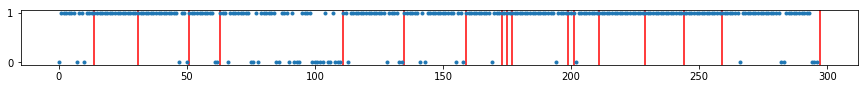

In [6]:
plt.figure(figsize=(15, 1))
for v in np.cumsum(cat_fields['n_cells']):
    plt.axvline(v, color='r')
plt.plot(kept_cells, '.')

# Posthoc analysis

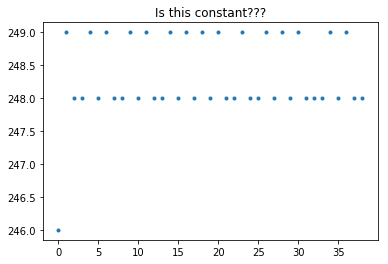

In [7]:
class TwoPhotonTraces():
    """ 
    Class that implements minimal fields to be used with COSMOS traces tools. 
    Should inherit from abstractbaseclass that 1P traces implements.
    """
    
    def __init__(self, C, F, S, dt, led_frames, name):
        self.C = C
        self.F = F
        self.S = S
        self.dt = dt
        self.ncells = C.shape[0]
        self.led_frames = led_frames
        self.name = name
        
plt.plot(np.diff(led_frames), '.')
plt.title('Is this constant???')

kept = np.where(kept_cells == 1)[0]
dt = 1/30 # Assume constant frame rate, we're actually just aligning to the TTL frames
spikes = np.concatenate([np.array(m.todense()) for m in cat_fields['S']])
cat_traces = TwoPhotonTraces(cat_fields['C'][kept, :], cat_fields['C_raw'][kept, :],
                             spikes, dt, led_frames, mouse)


In [8]:
# Get trial averages etc assuming the grating stimulus has default parameters!
is_cosmos = False
gs = utils.GratingStimulus(cat_traces, is_cosmos, make_plot=False, osi_thresh=.65, use_filtered='F')

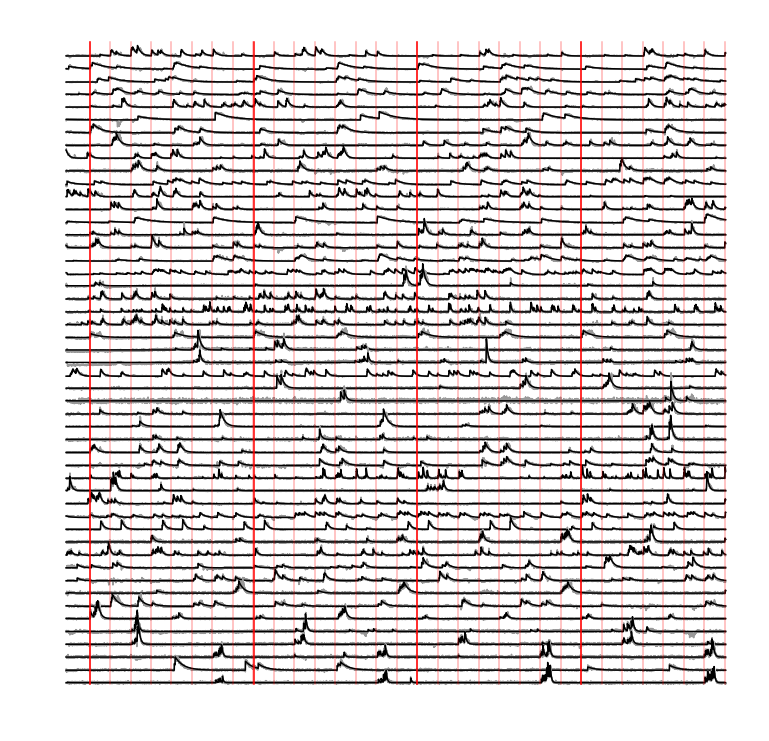

In [9]:
gs.make_active_cell_raster(gs.chosen_anova, cells_to_plot=50, start=1, stop=8000)

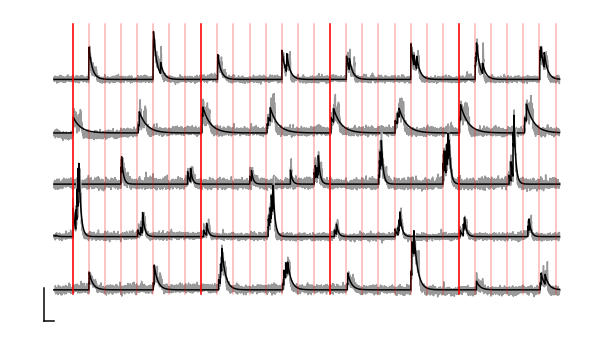

In [10]:
# This plot can only be generated with m194, dataset 12
if mouse == 'm194':
    plt.figure(figsize=(10,6))
    gs.make_active_cell_raster([209, 80, 140, 169, 182], cells_to_plot=100, start=1, stop=7800, spacing=8, new_figure=False)
    yy = plt.ylim()
    plt.ylim([yy[0] - 4, yy[1]])
    xx = plt.xlim()
    plt.xlim([xx[0] - 1, xx[1]])
    plt.plot([-5, -5], [-5, 0], 'k')
    plt.plot([-5, 0], [-5, -5], 'k')
    plt.savefig('plots/2p-chosen-cells-z5-5seconds-' + mouse + '.pdf', bbox_inches='tight')

/home/deisseroth/Code/COSMOS/cosmos/traces/trace_analysis_utils.py:209: RuntimeWarning: invalid value encountered in true_divide
  trace = trace / np.percentile(trace, thresh)
/home/deisseroth/venv2/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


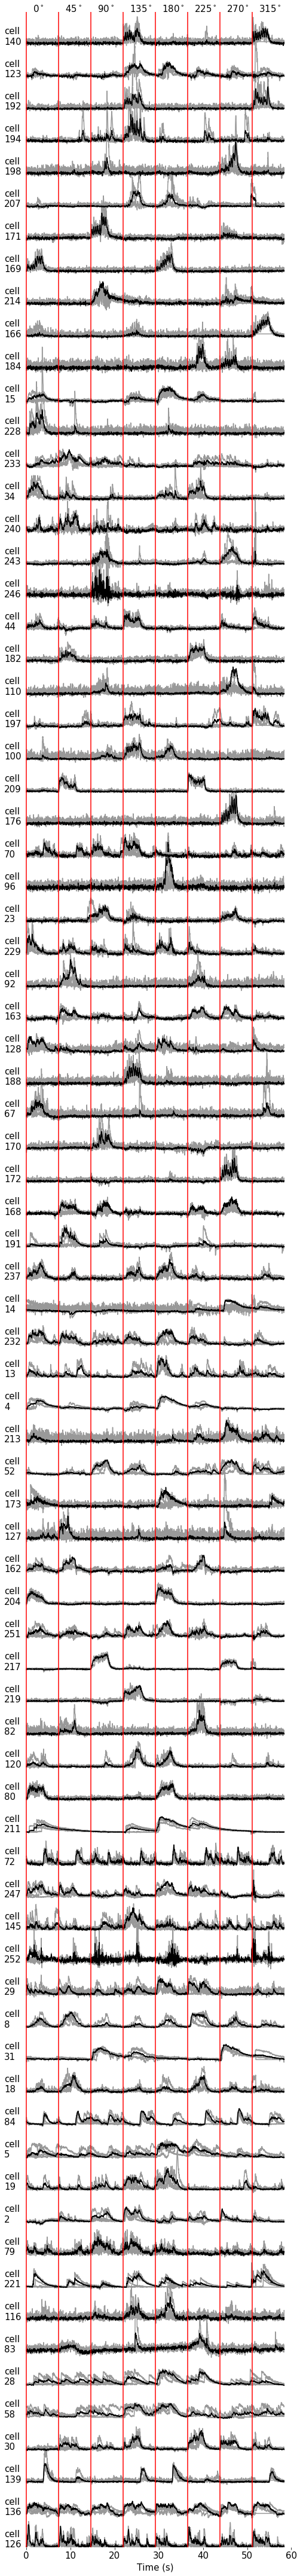

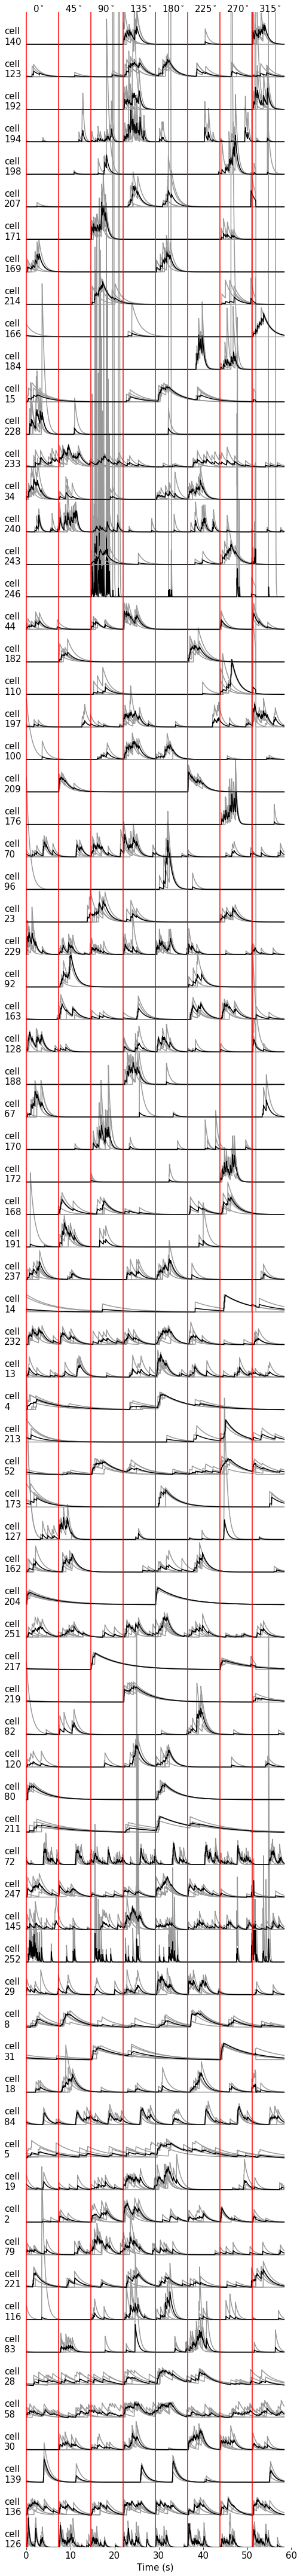

In [11]:
gs.chosen_anova = np.array(gs.chosen_anova)
if len(gs.chosen_anova) > 2:
    ordered_anova_idx = gs.chosen_anova[np.argsort(gs.osis[gs.chosen_anova])][::-1]
else:
    ordered_anova_idx = gs.chosen_anova
utils.plot_average_visual_response(gs.trial_F, gs.grating_onset_frames, ordered_anova_idx)
utils.plot_average_visual_response(gs.trial_C, gs.grating_onset_frames, ordered_anova_idx)

65


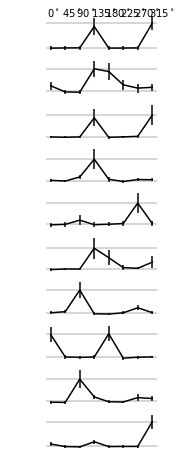

In [12]:
# This uses C not F
%matplotlib inline
gs._identify_sources()
print(len(gs.chosen_on_anova))
gs.make_linear_plots(ordered_anova_idx[:10], fixed_size=True)
plt.savefig('/home/deisseroth/Dropbox/2p-raster-top-10-' + mouse + '.pdf', bbox_inches='tight')

/home/deisseroth/venv2/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


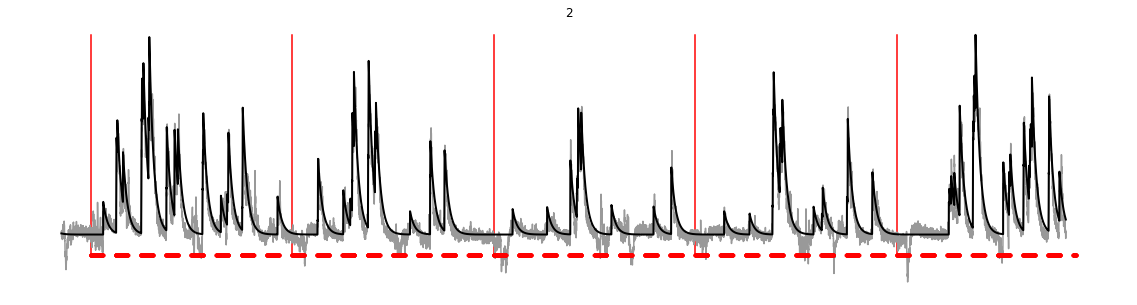

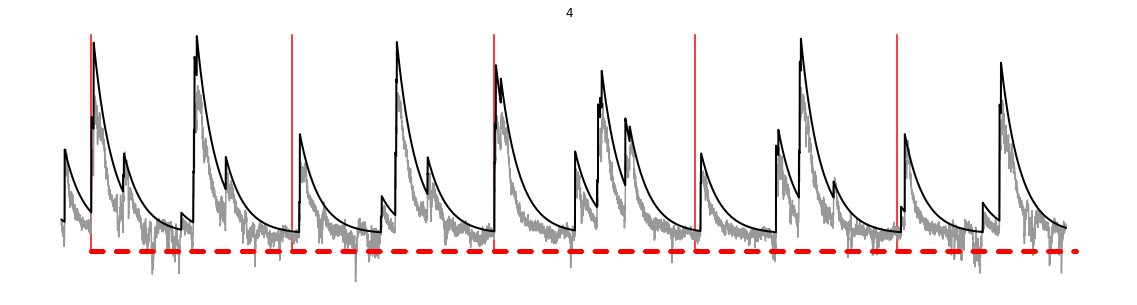

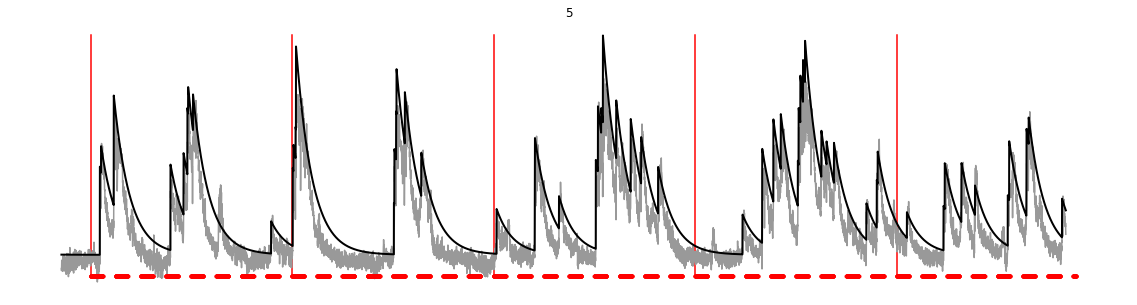

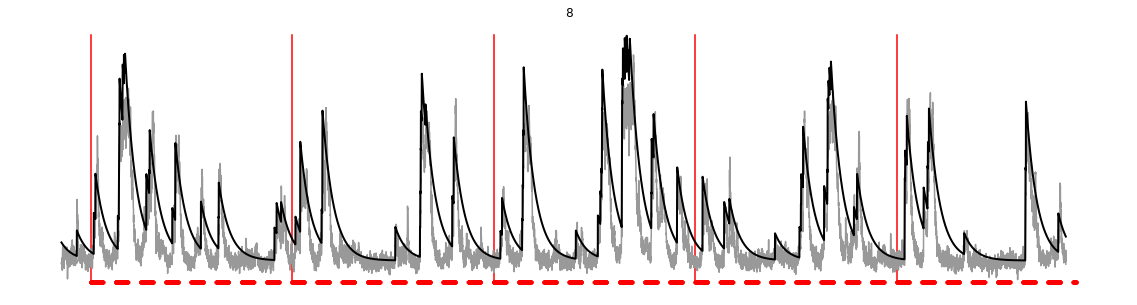

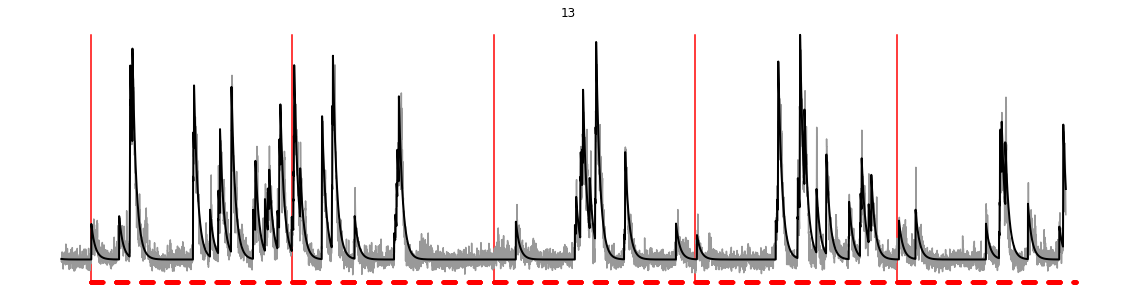

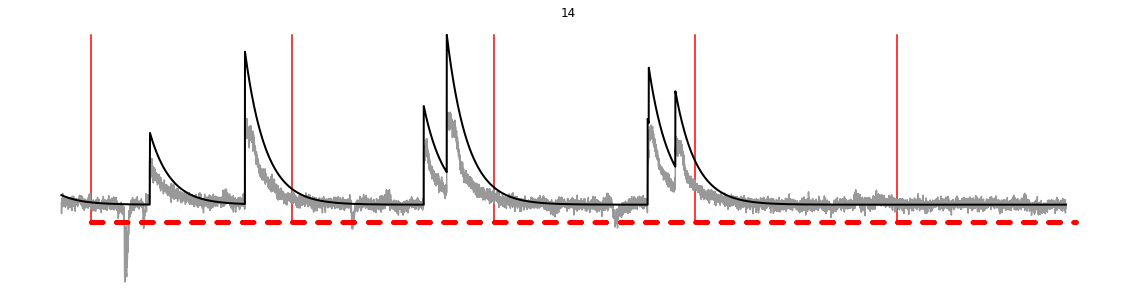

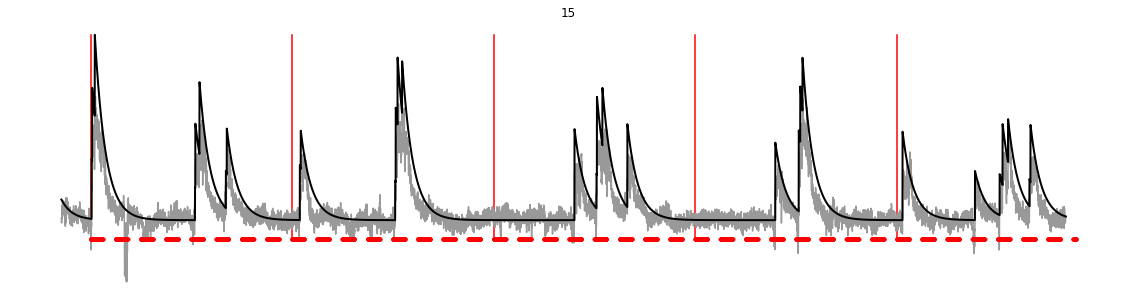

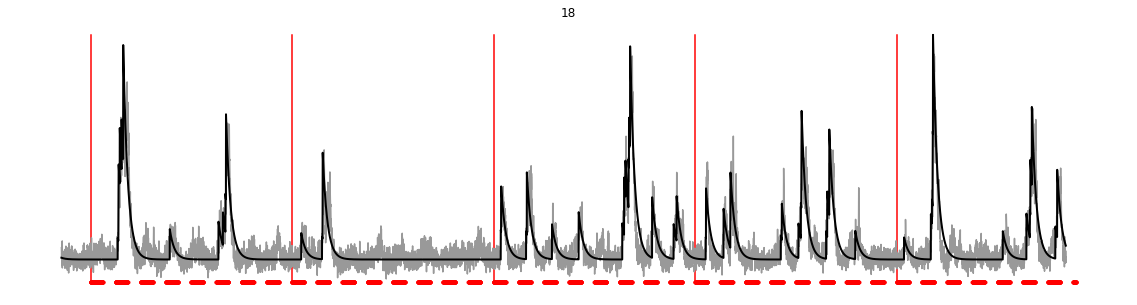

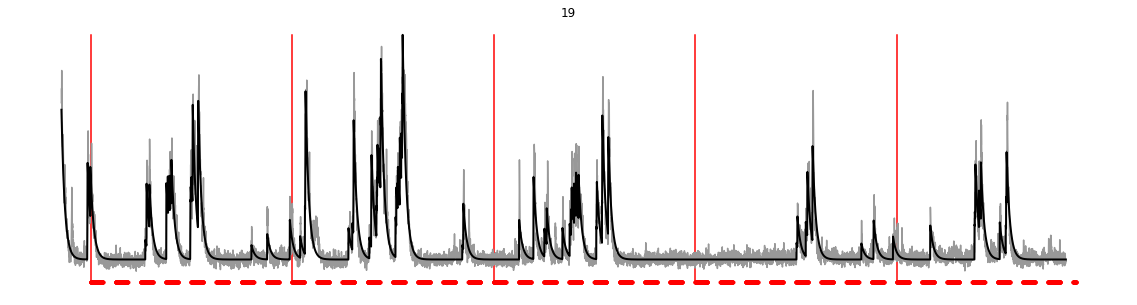

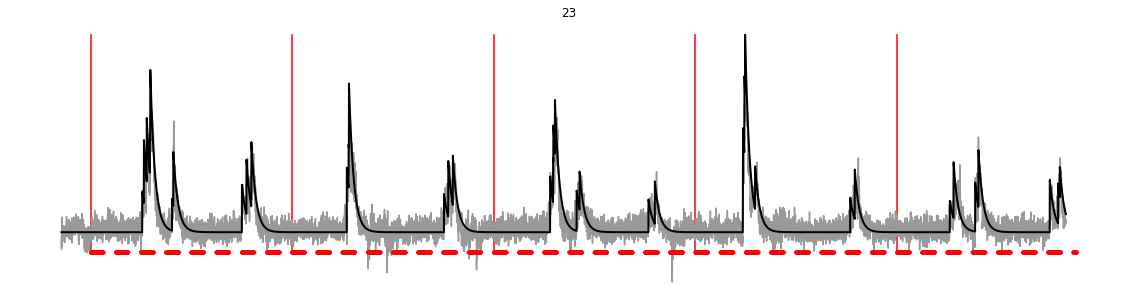

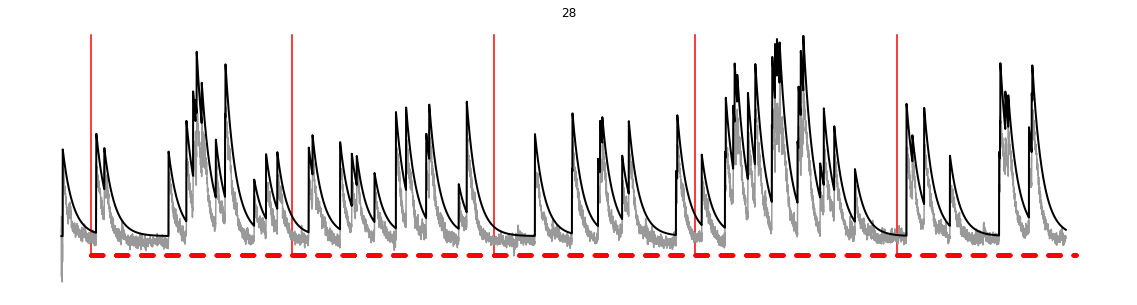

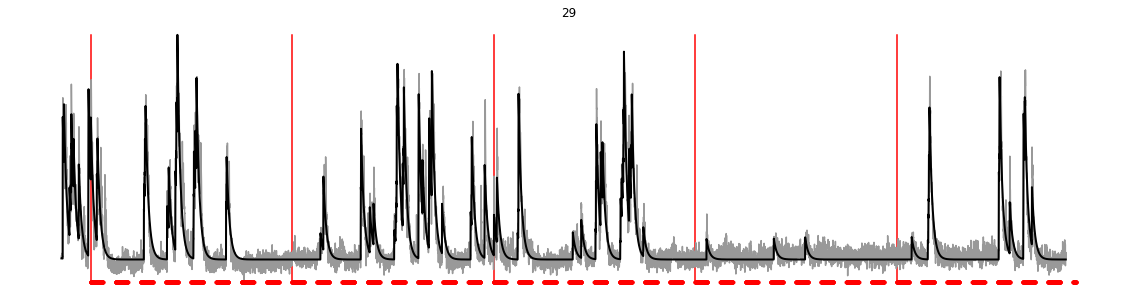

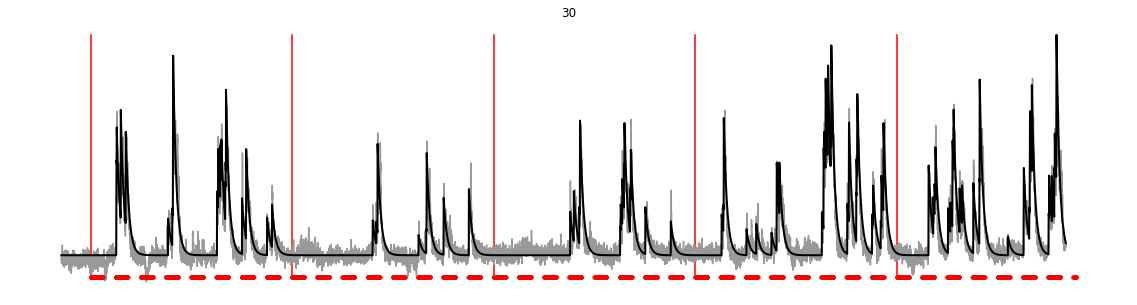

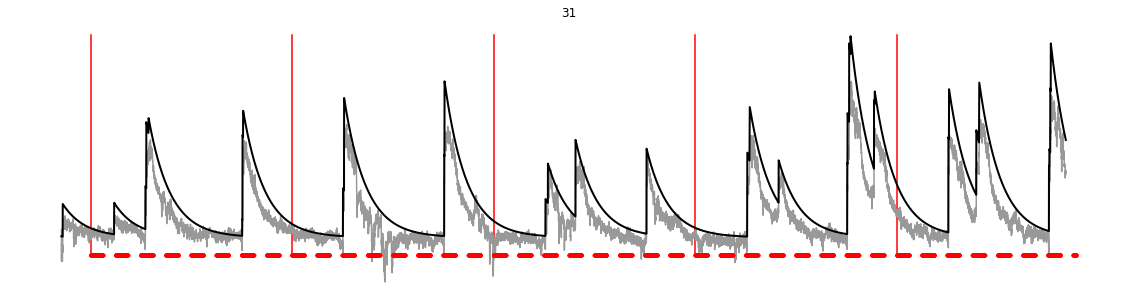

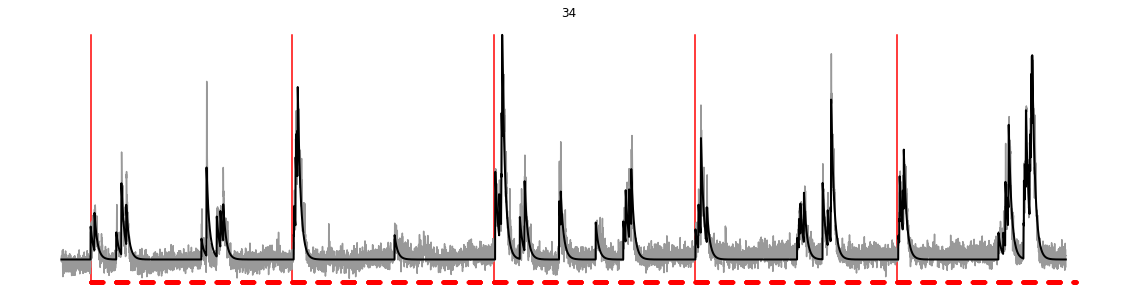

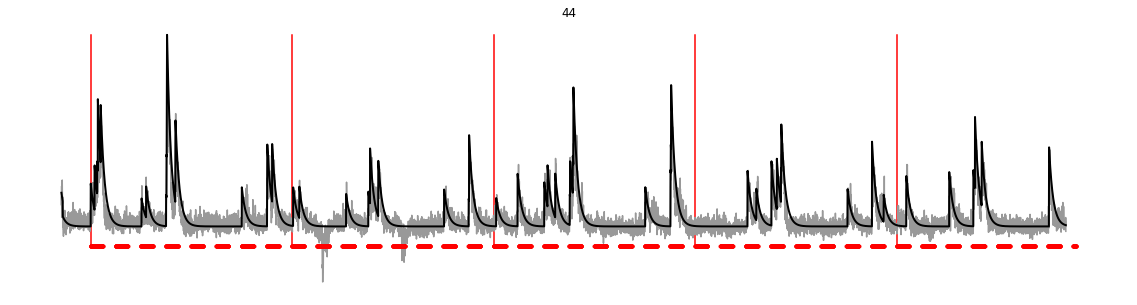

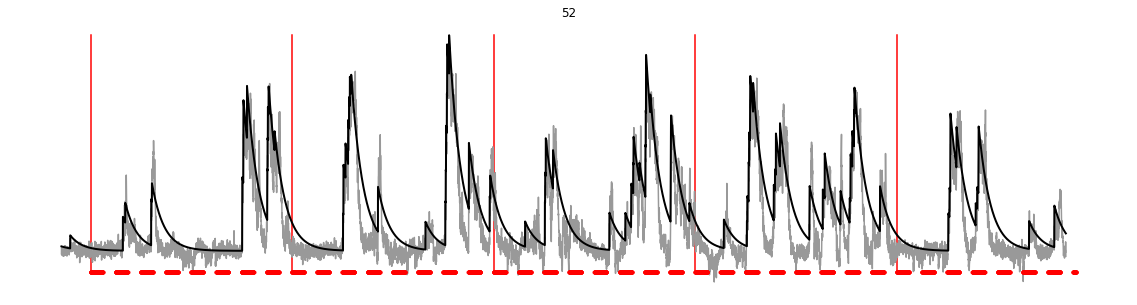

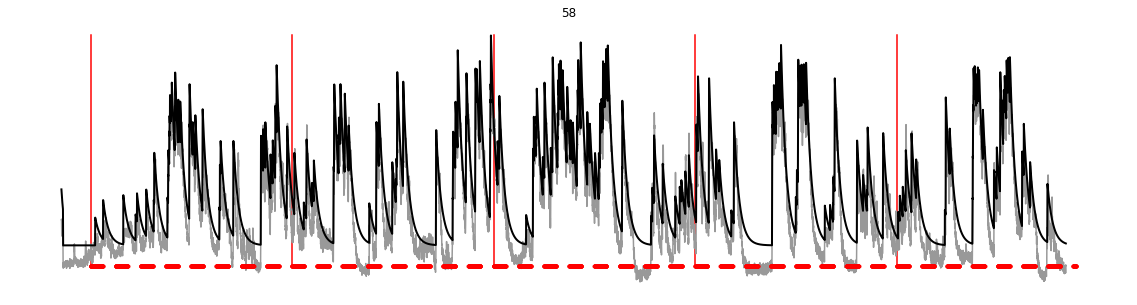

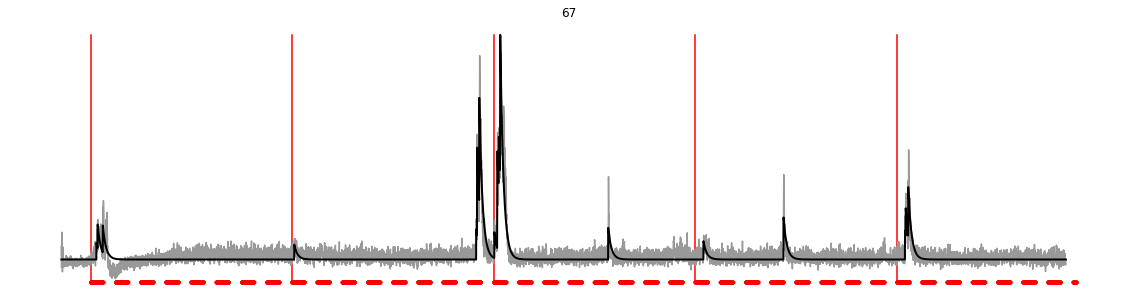

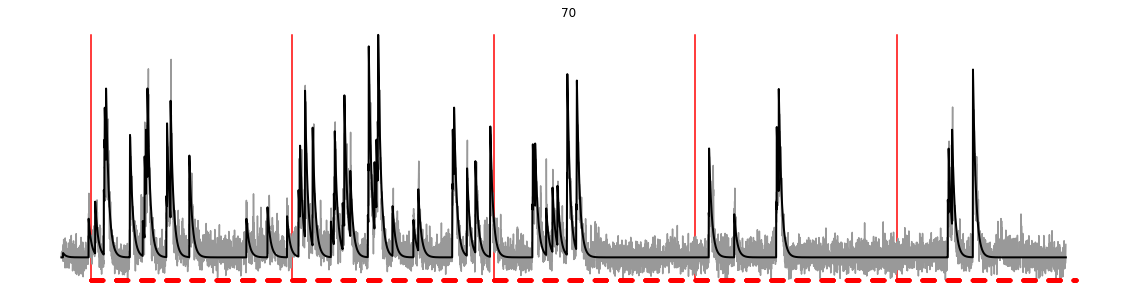

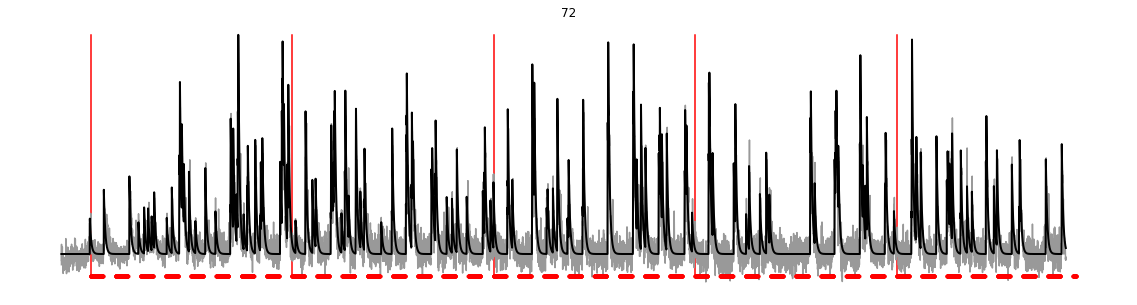

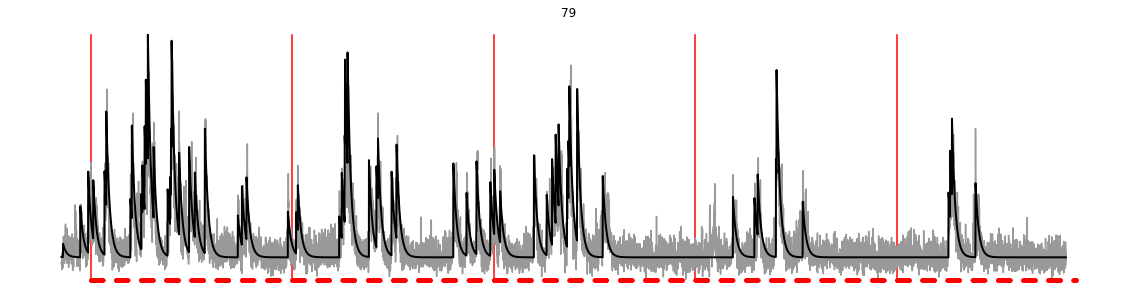

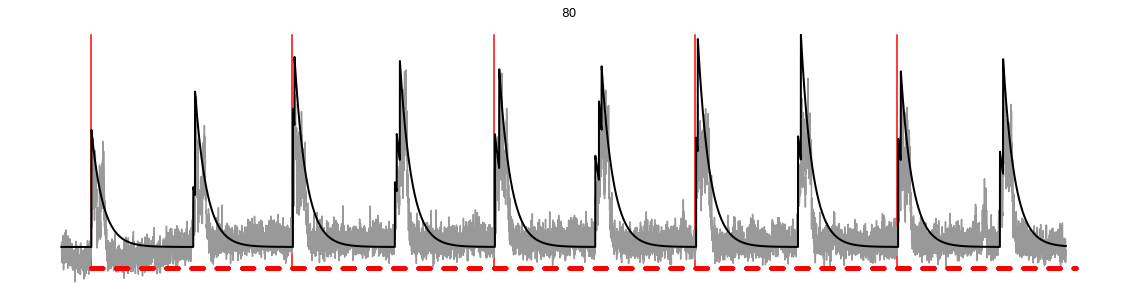

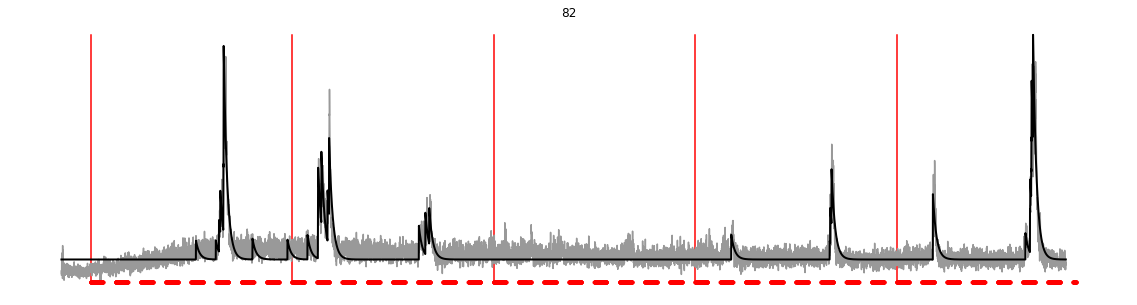

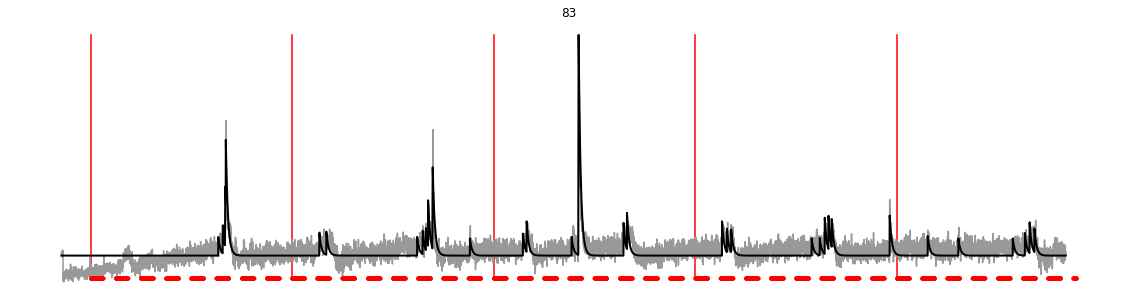

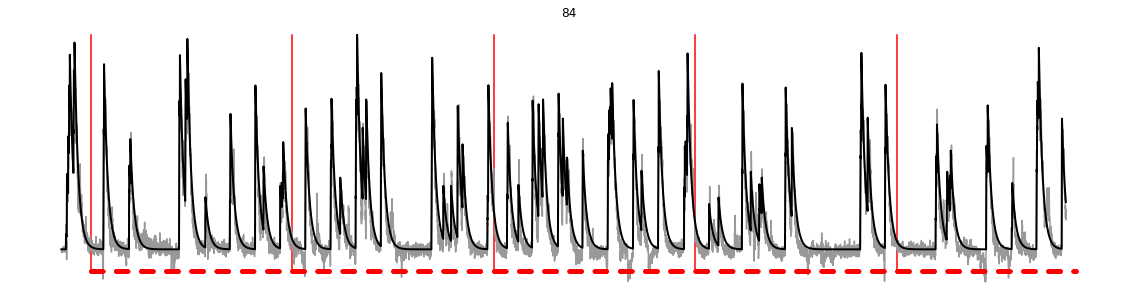

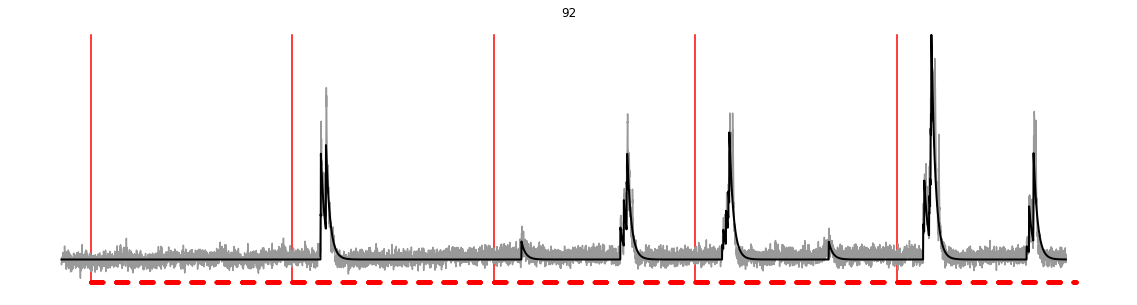

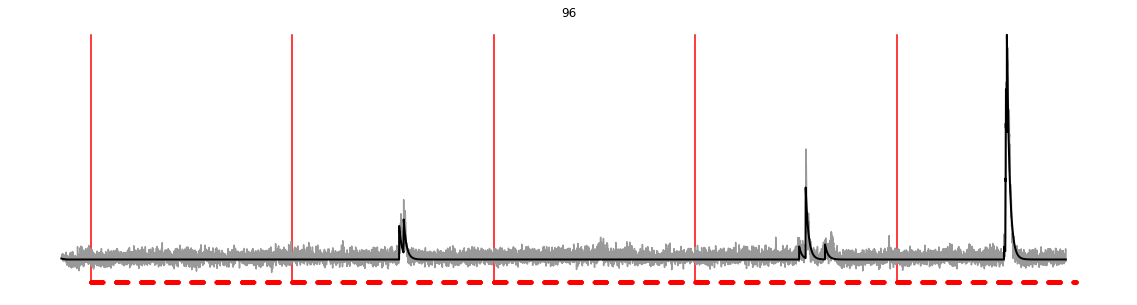

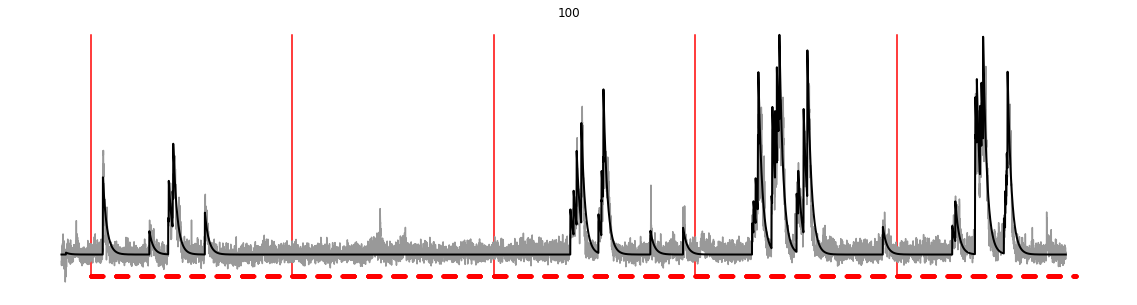

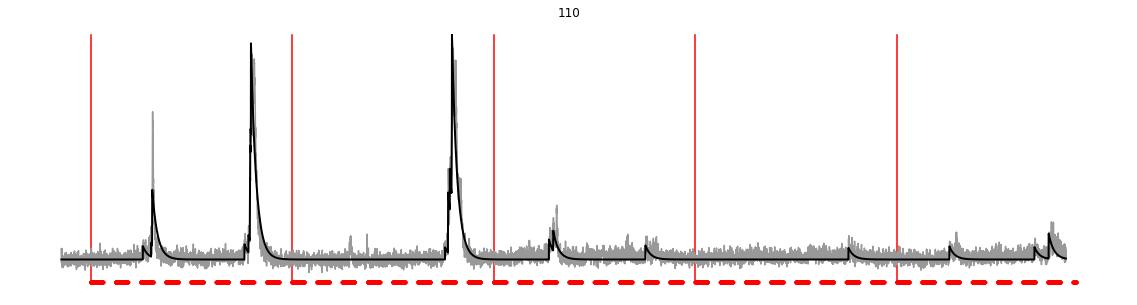

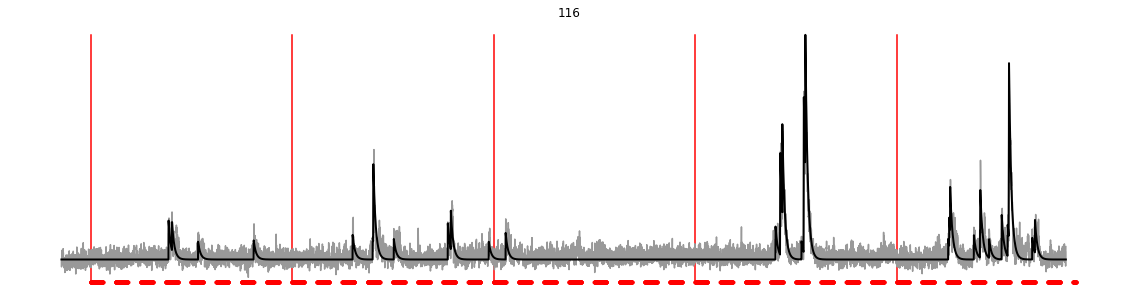

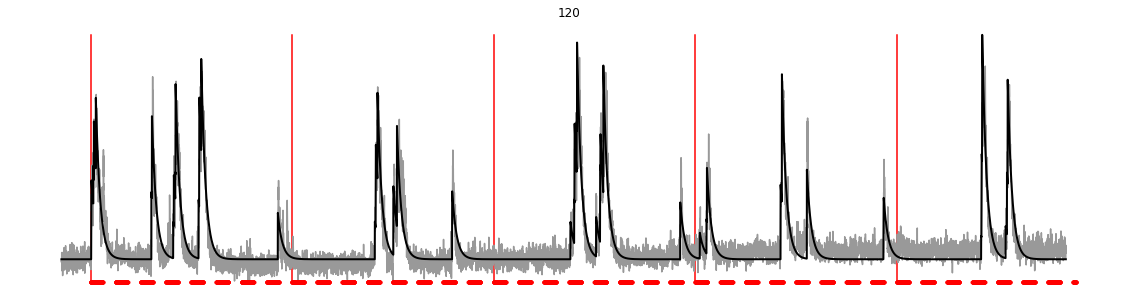

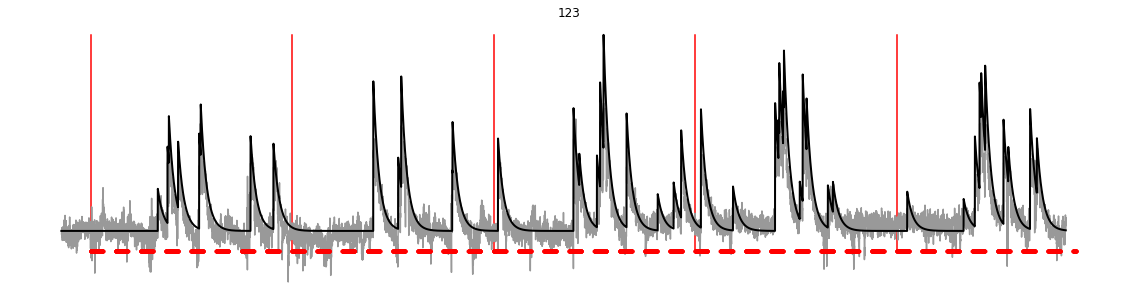

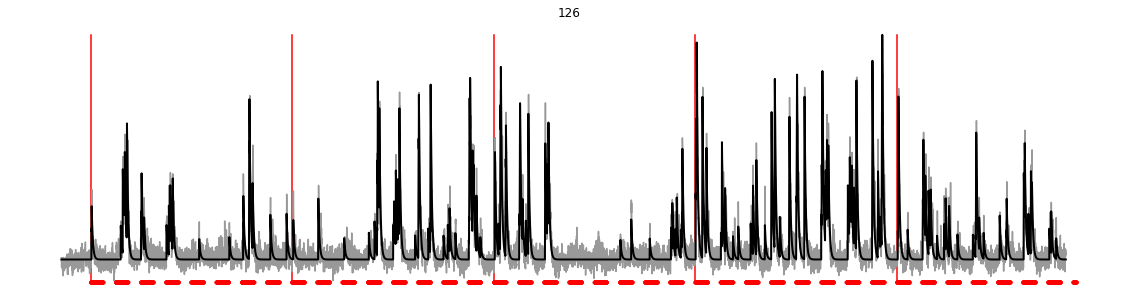

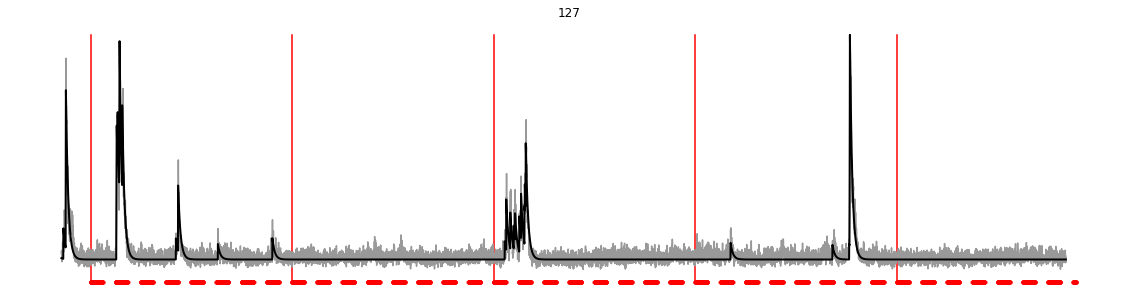

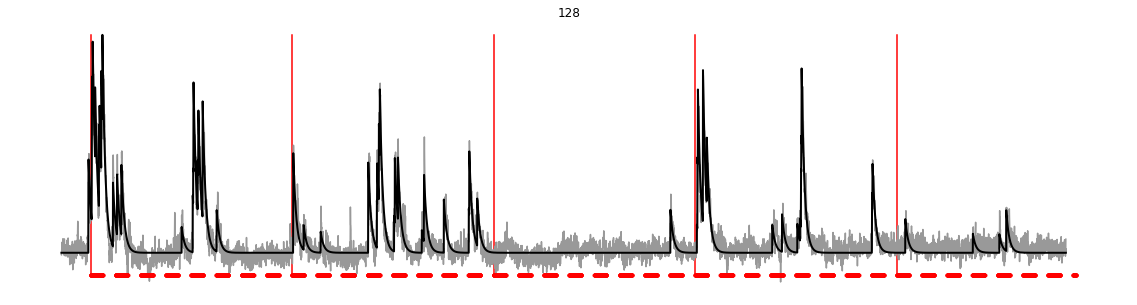

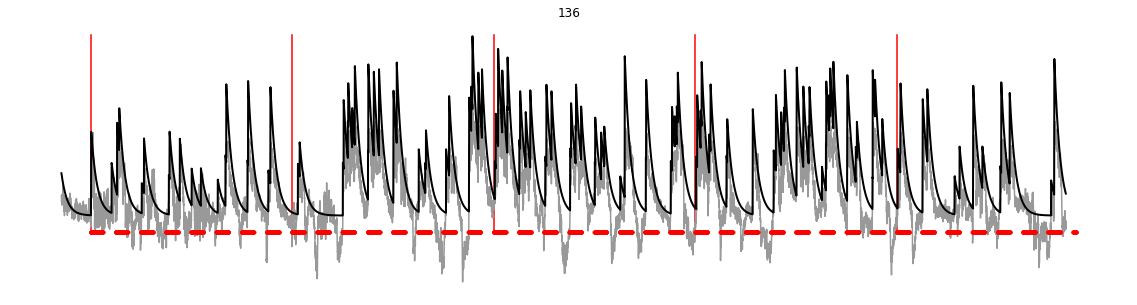

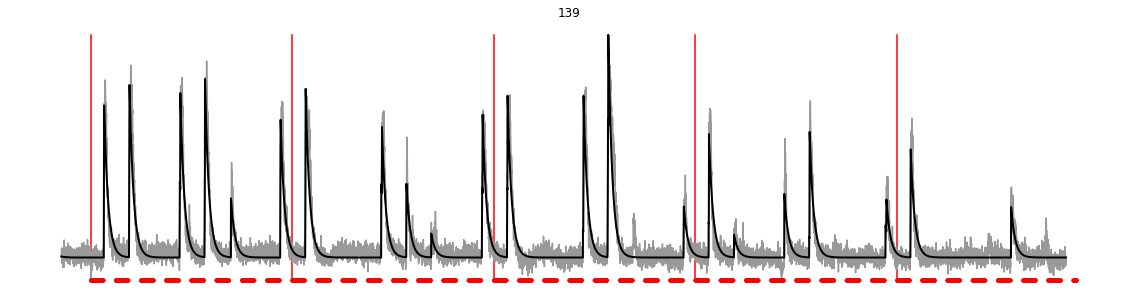

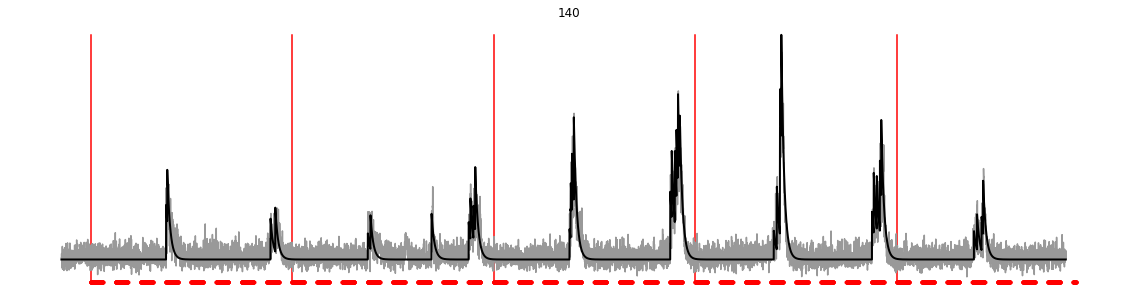

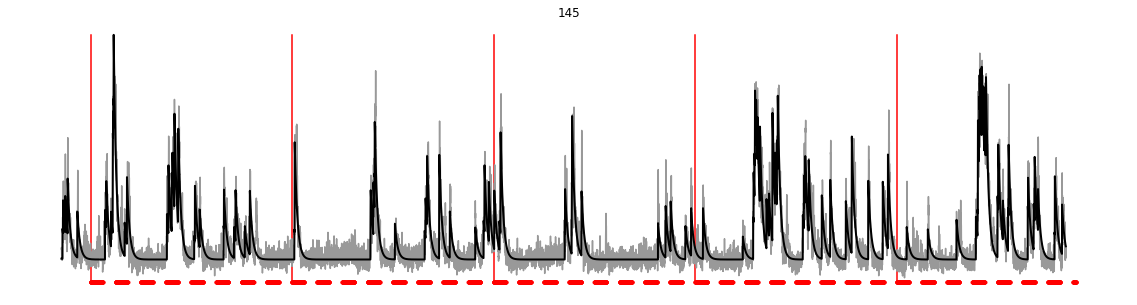

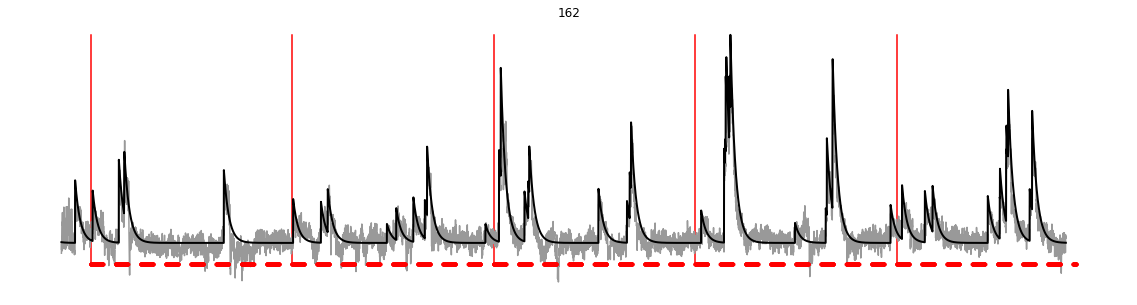

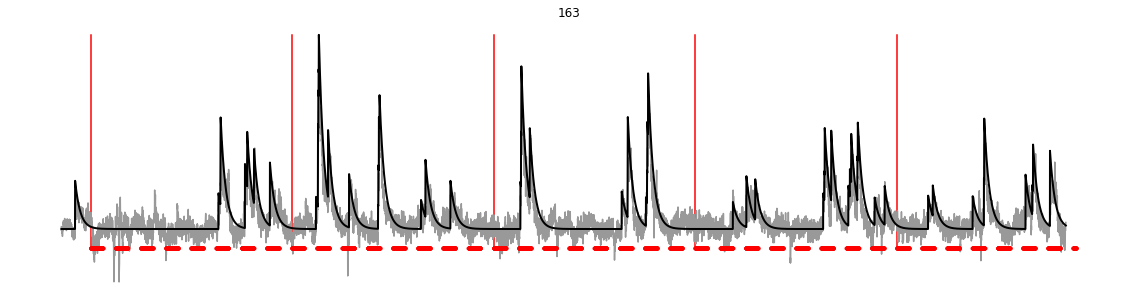

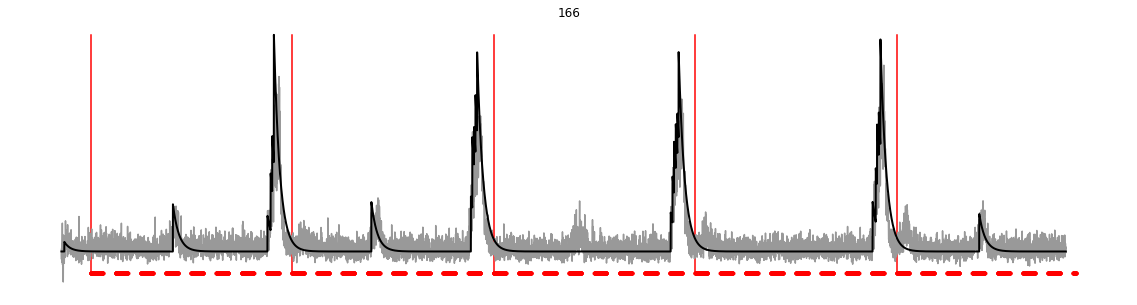

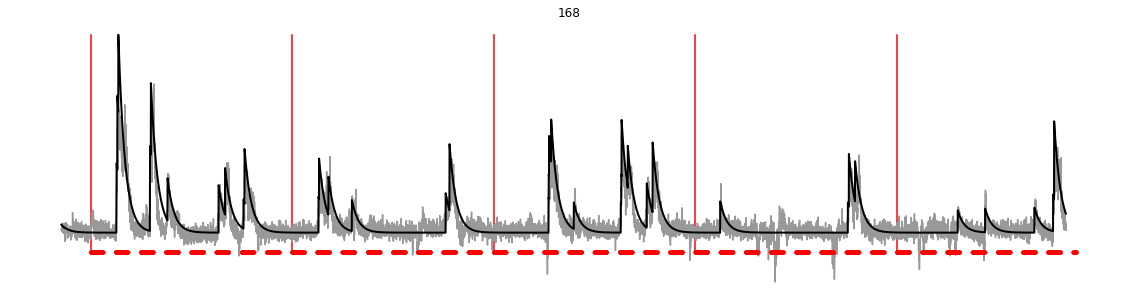

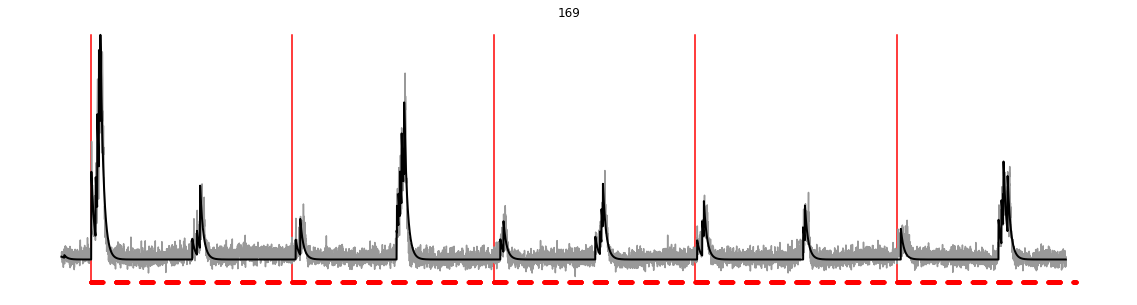

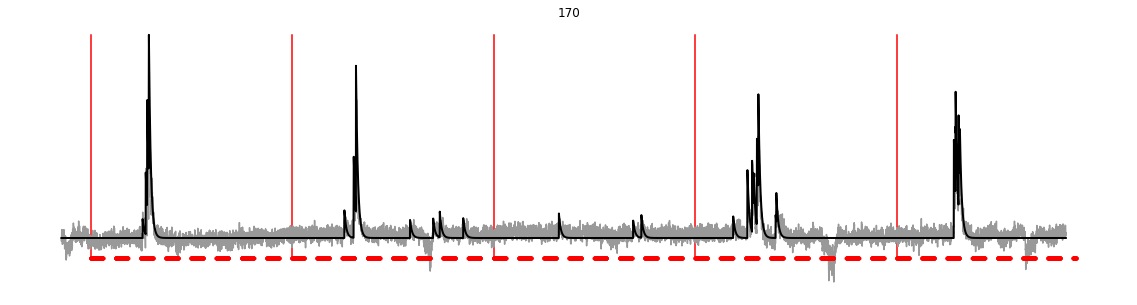

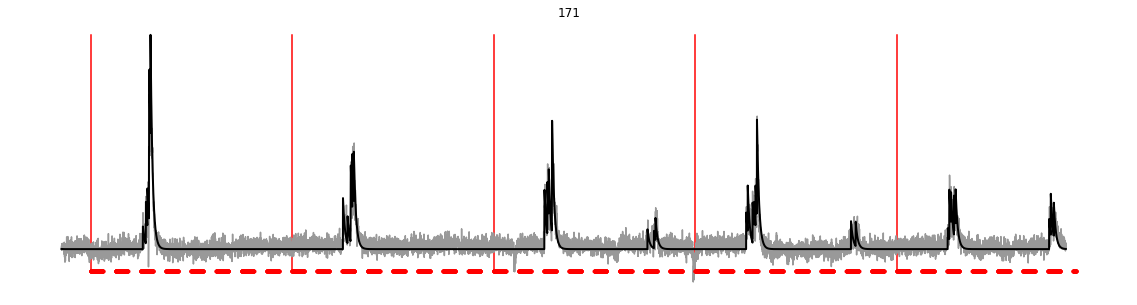

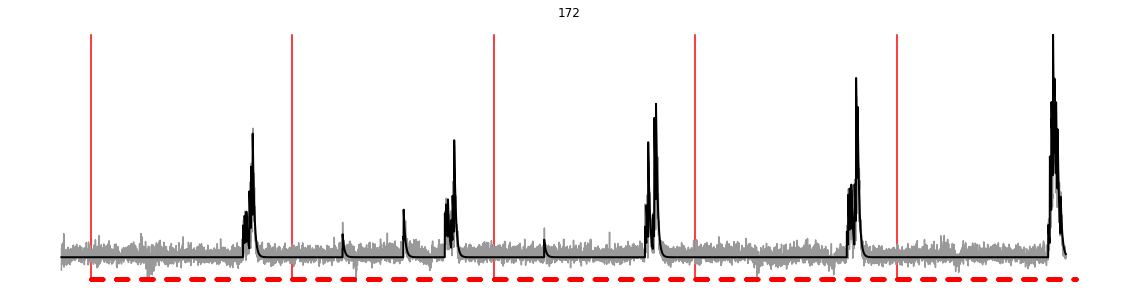

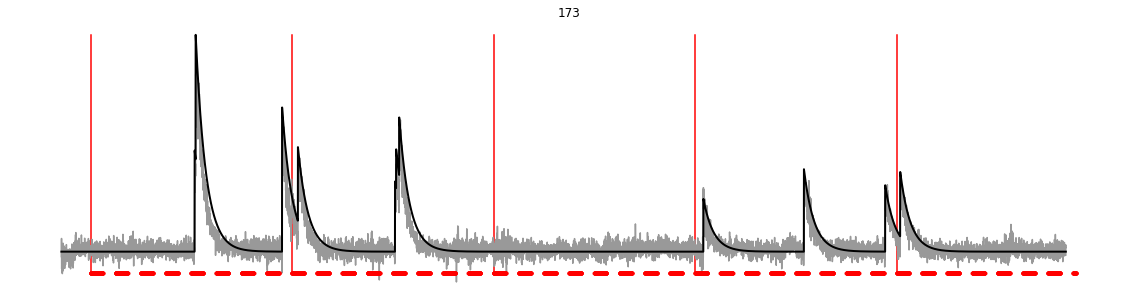

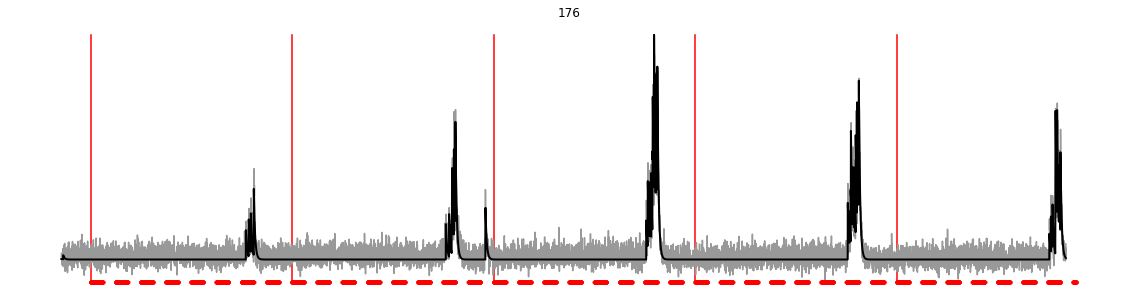

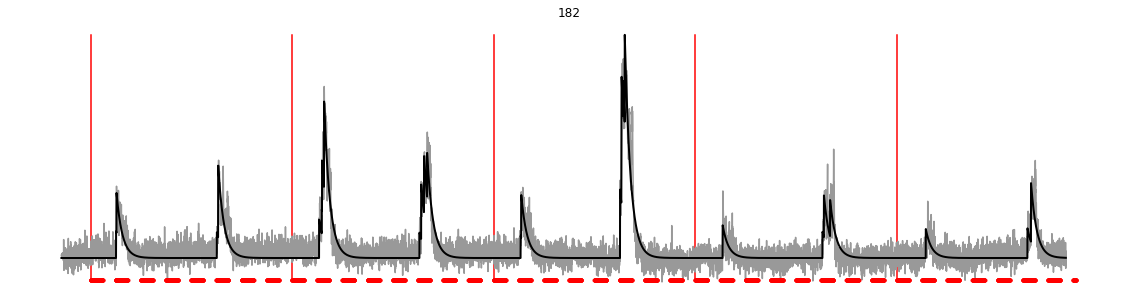

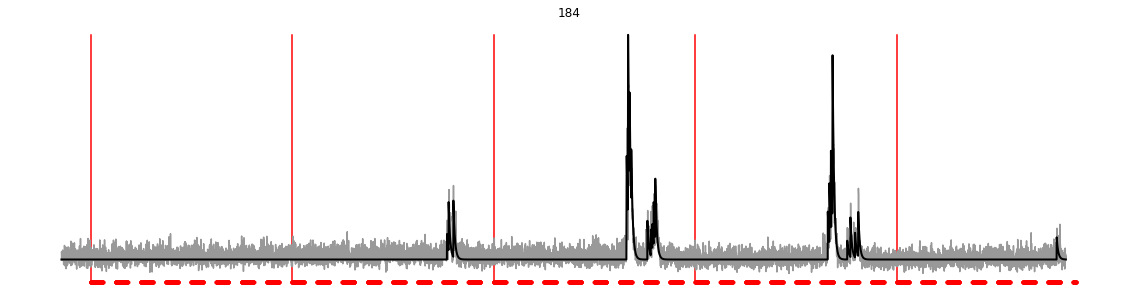

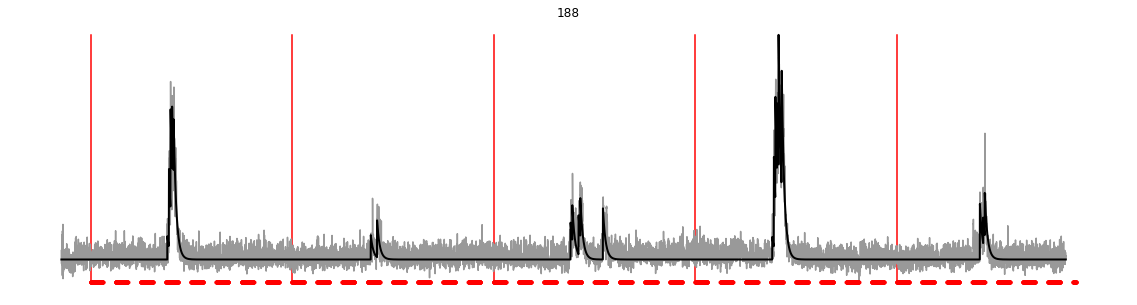

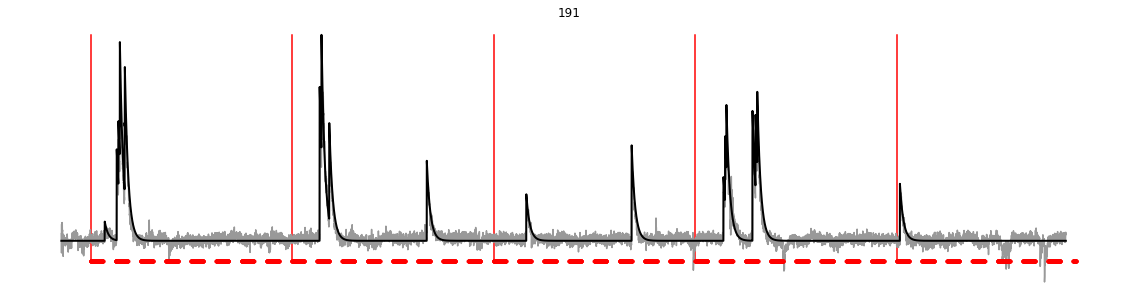

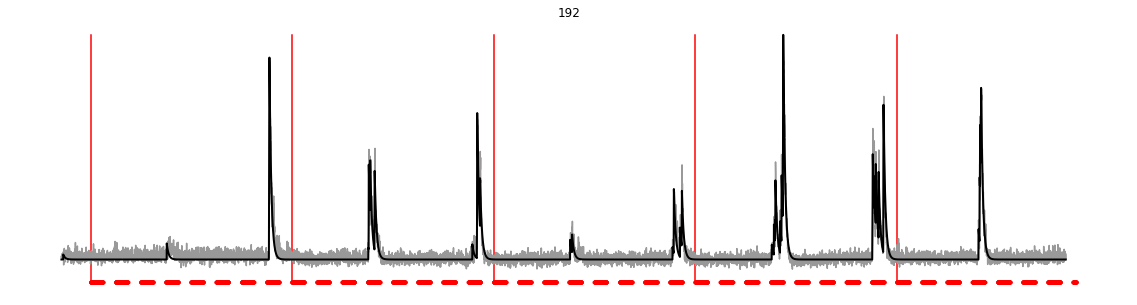

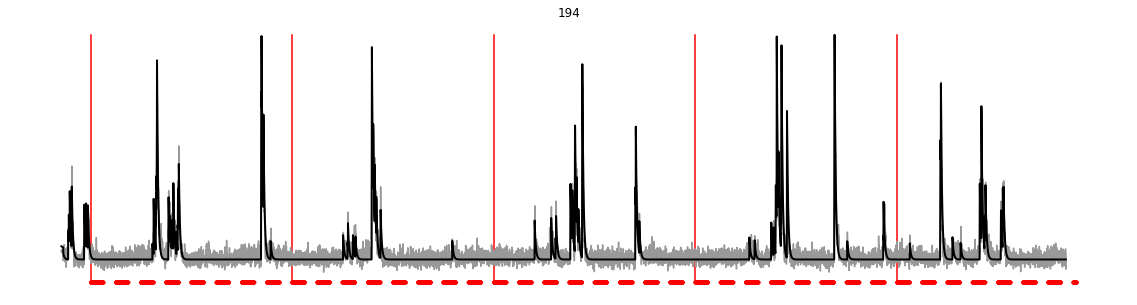

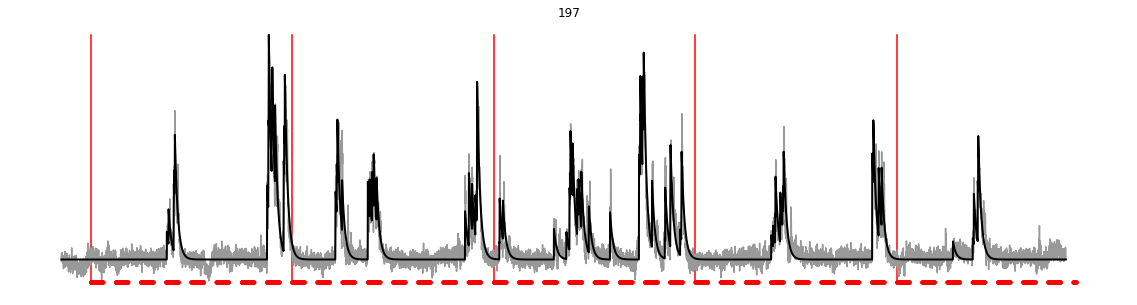

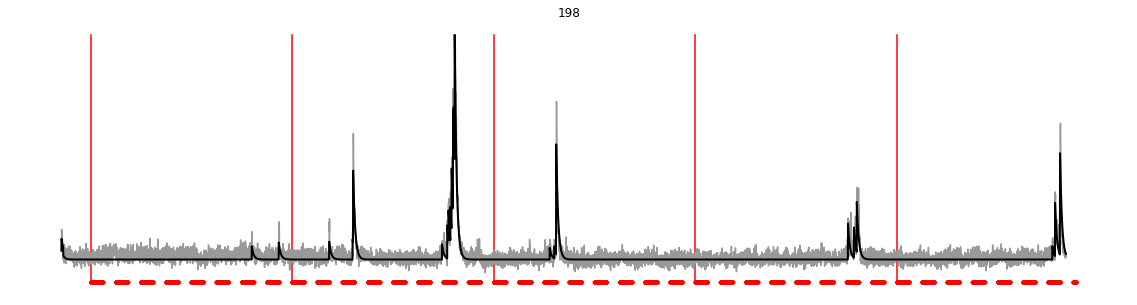

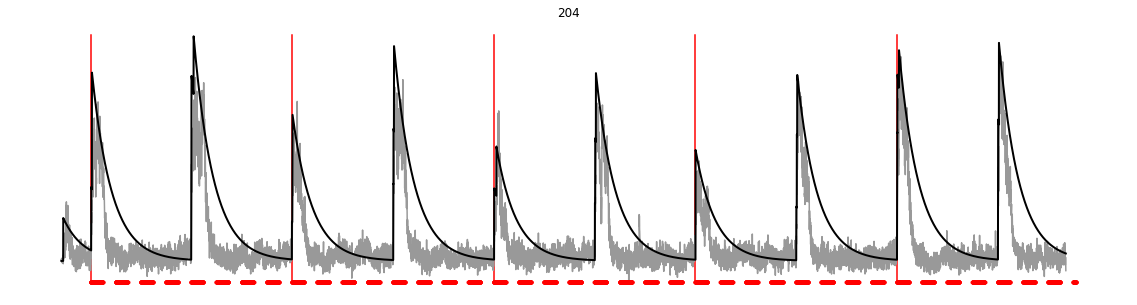

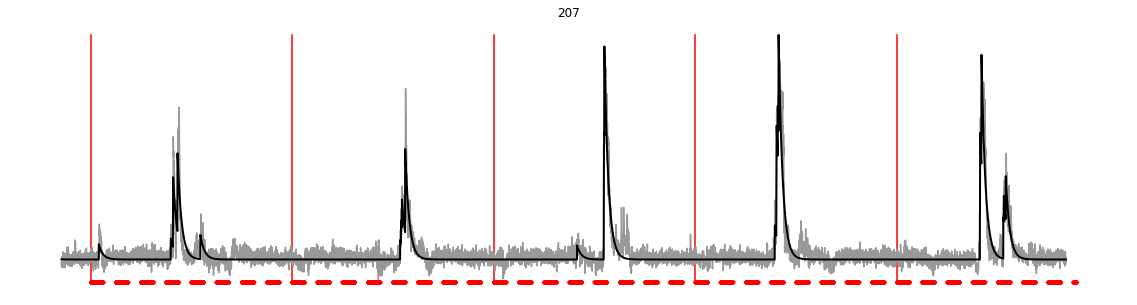

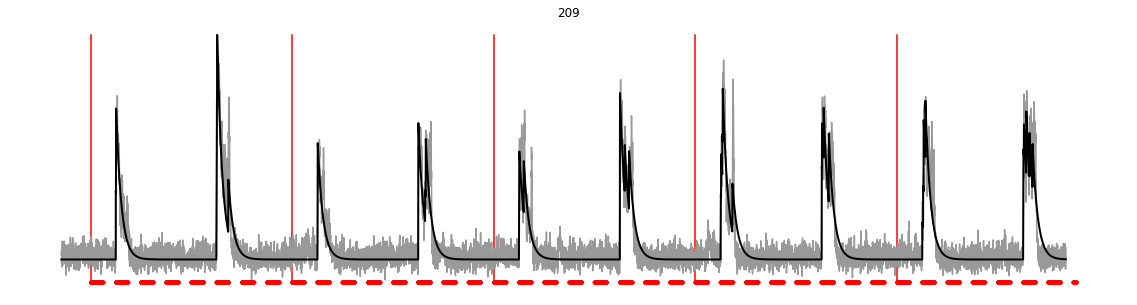

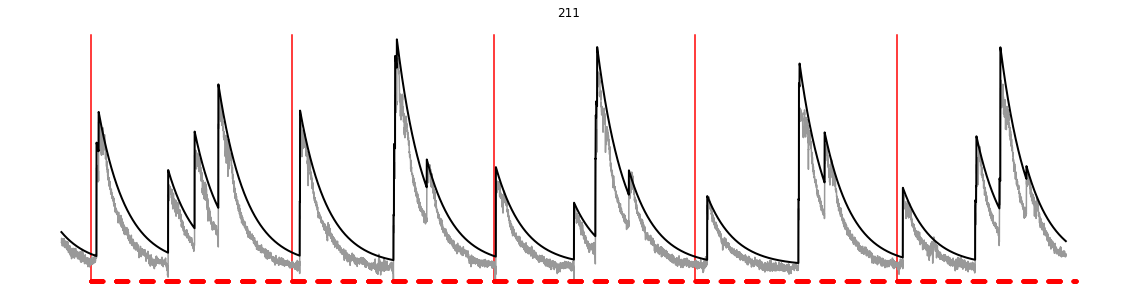

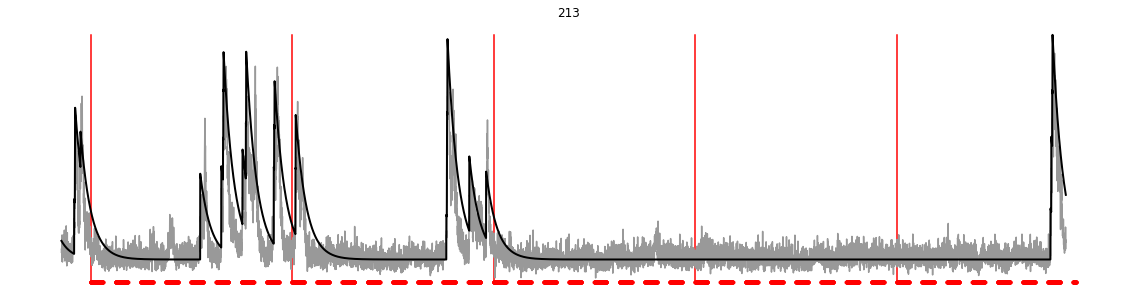

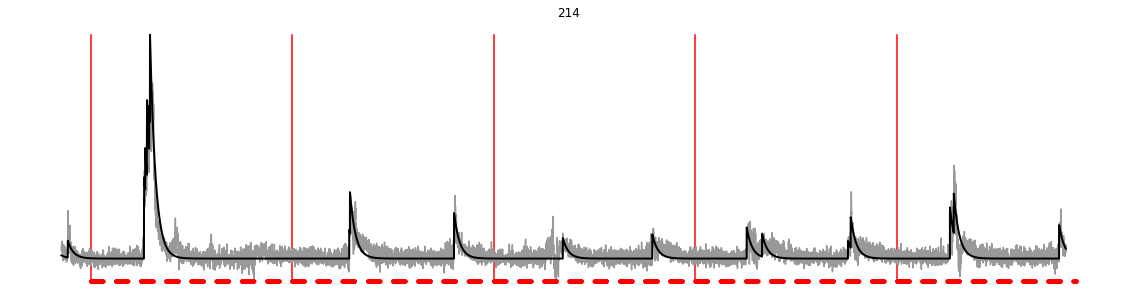

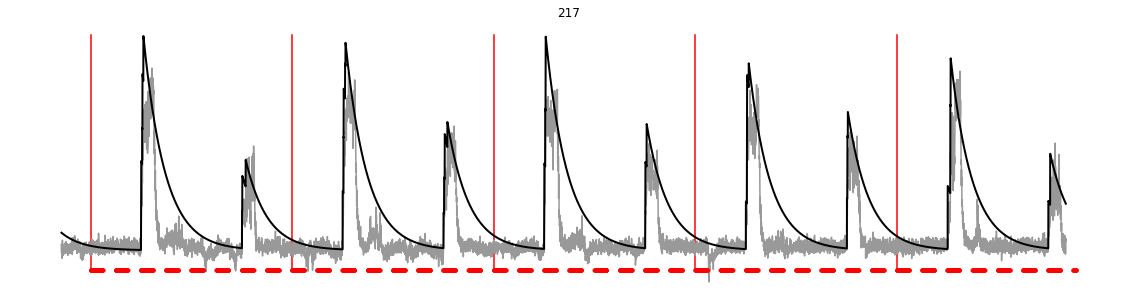

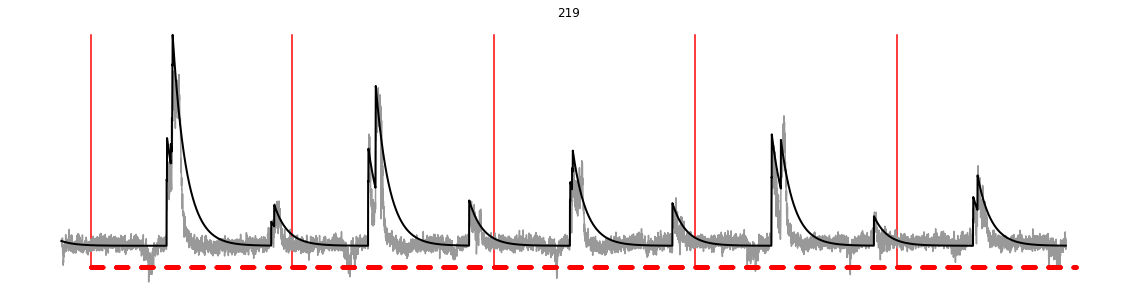

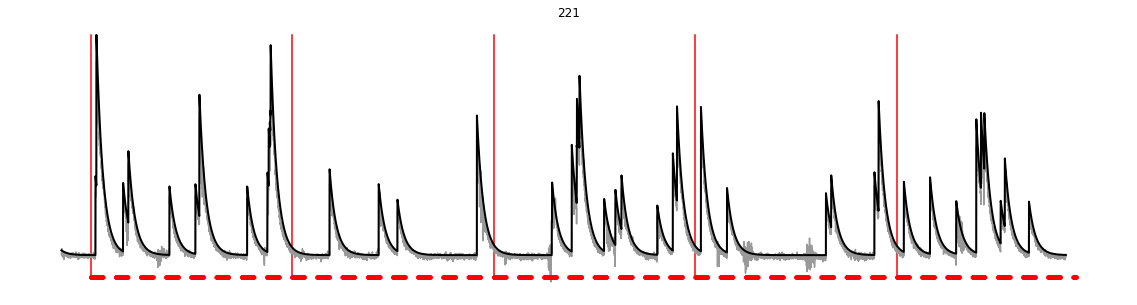

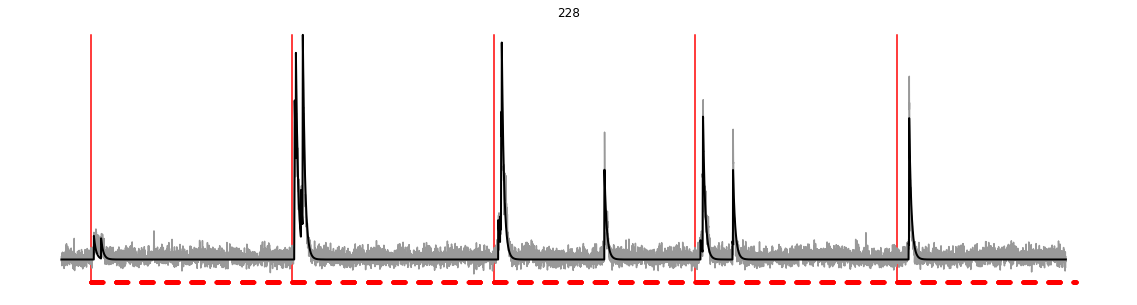

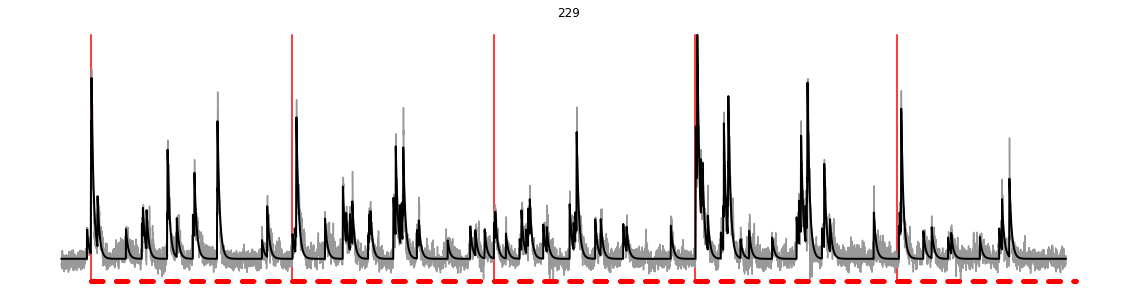

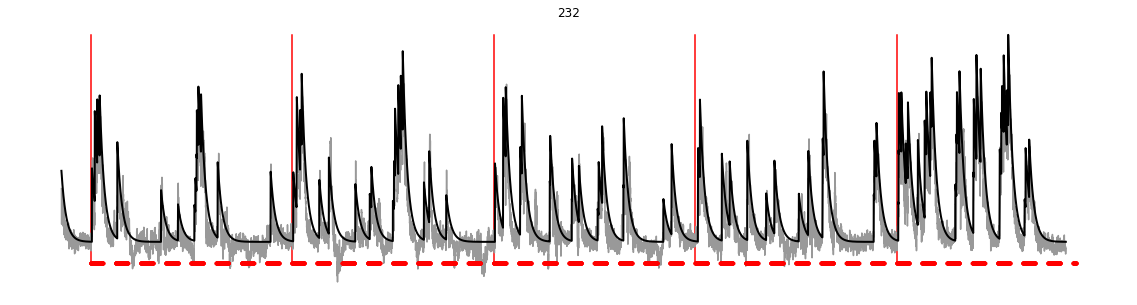

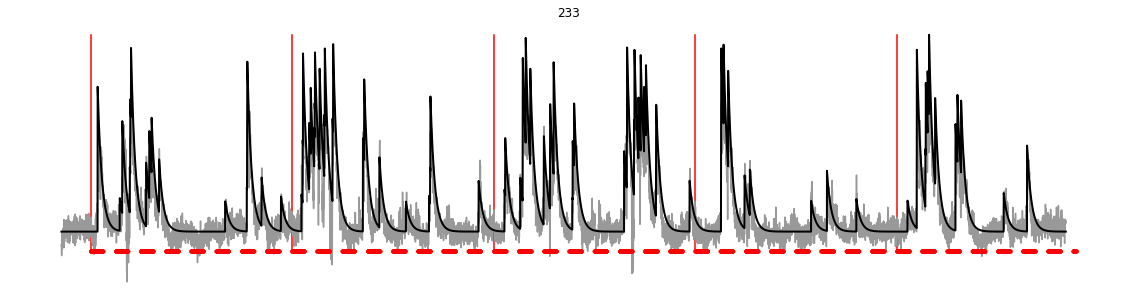

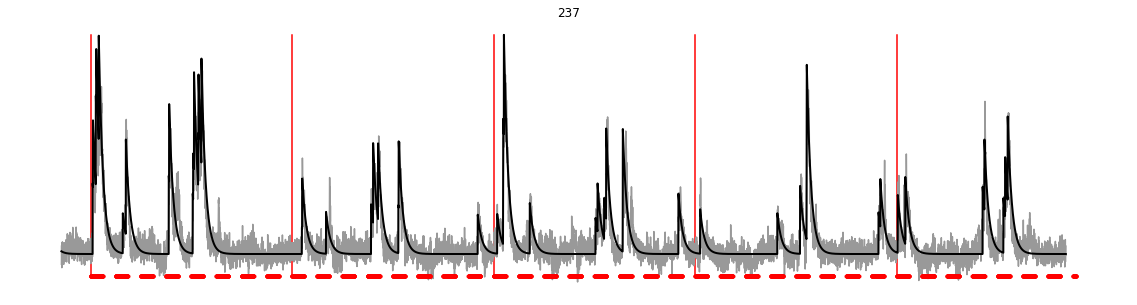

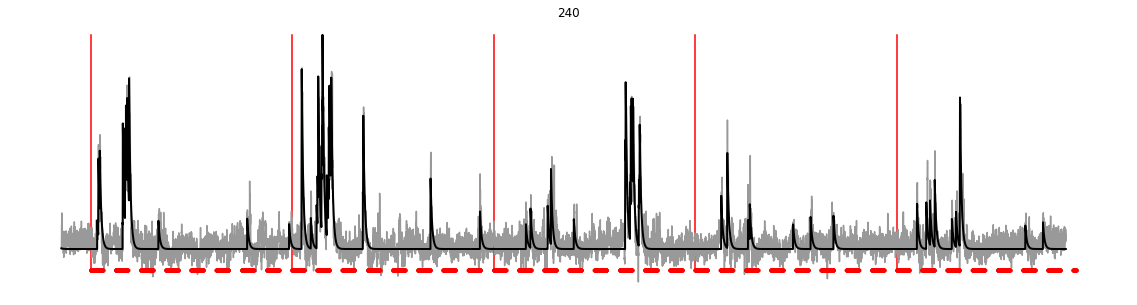

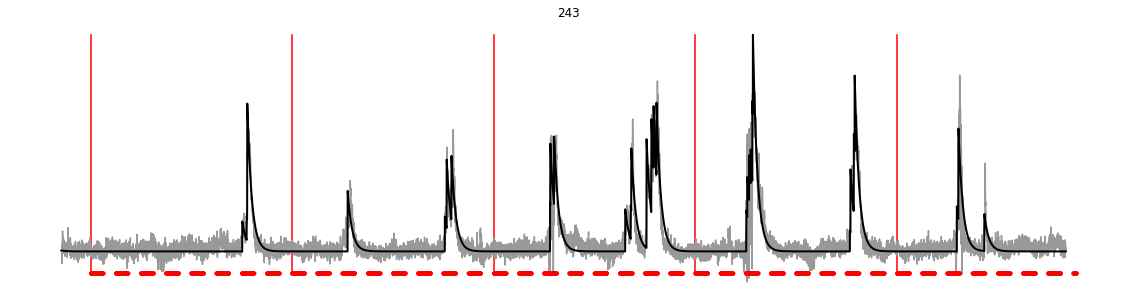

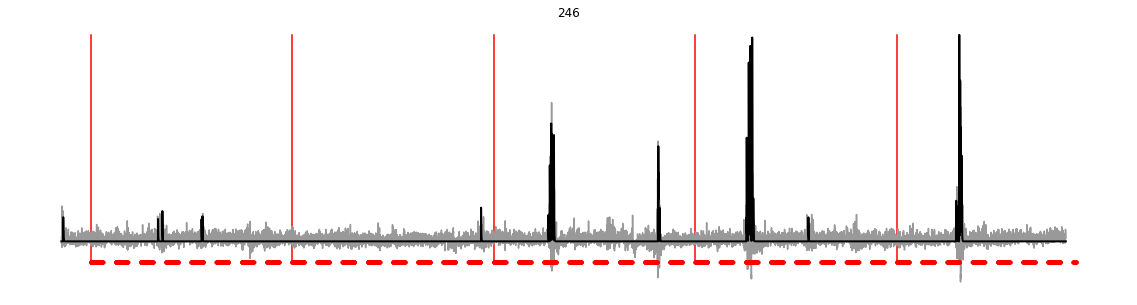

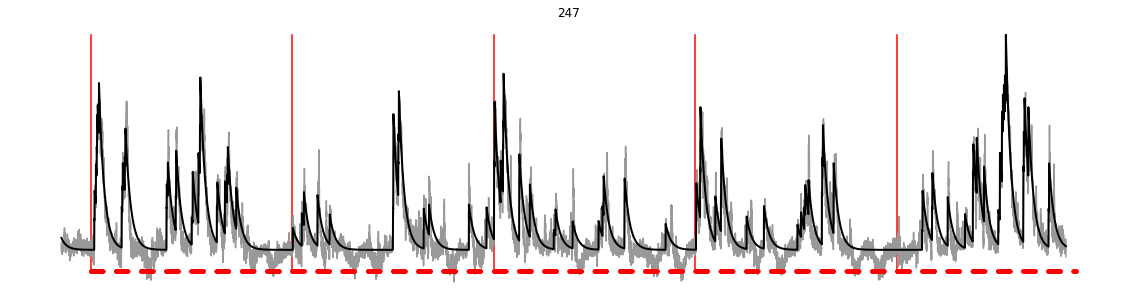

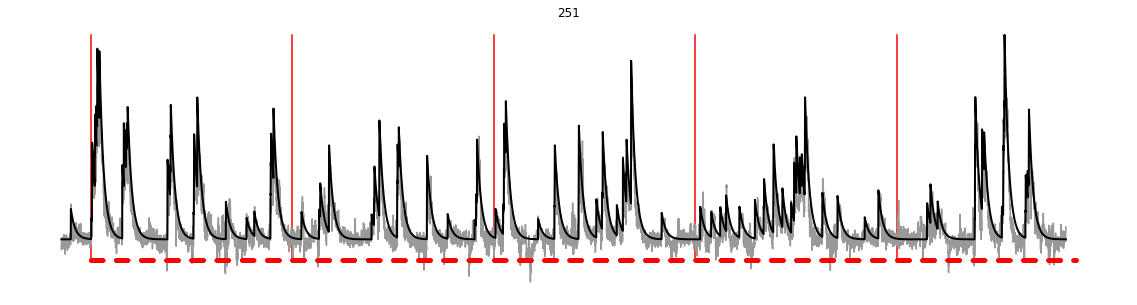

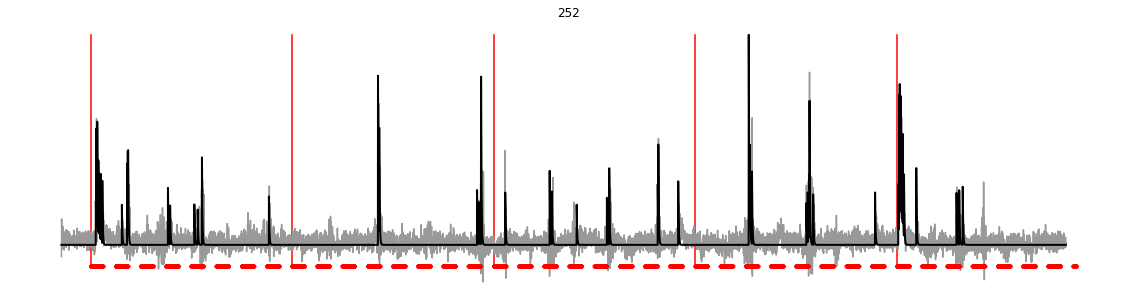

In [13]:
# Plot individual traces
end = 9900
for idx in gs.chosen_anova:
    gs.make_single_trace_plot(idx, end=end, title=True)

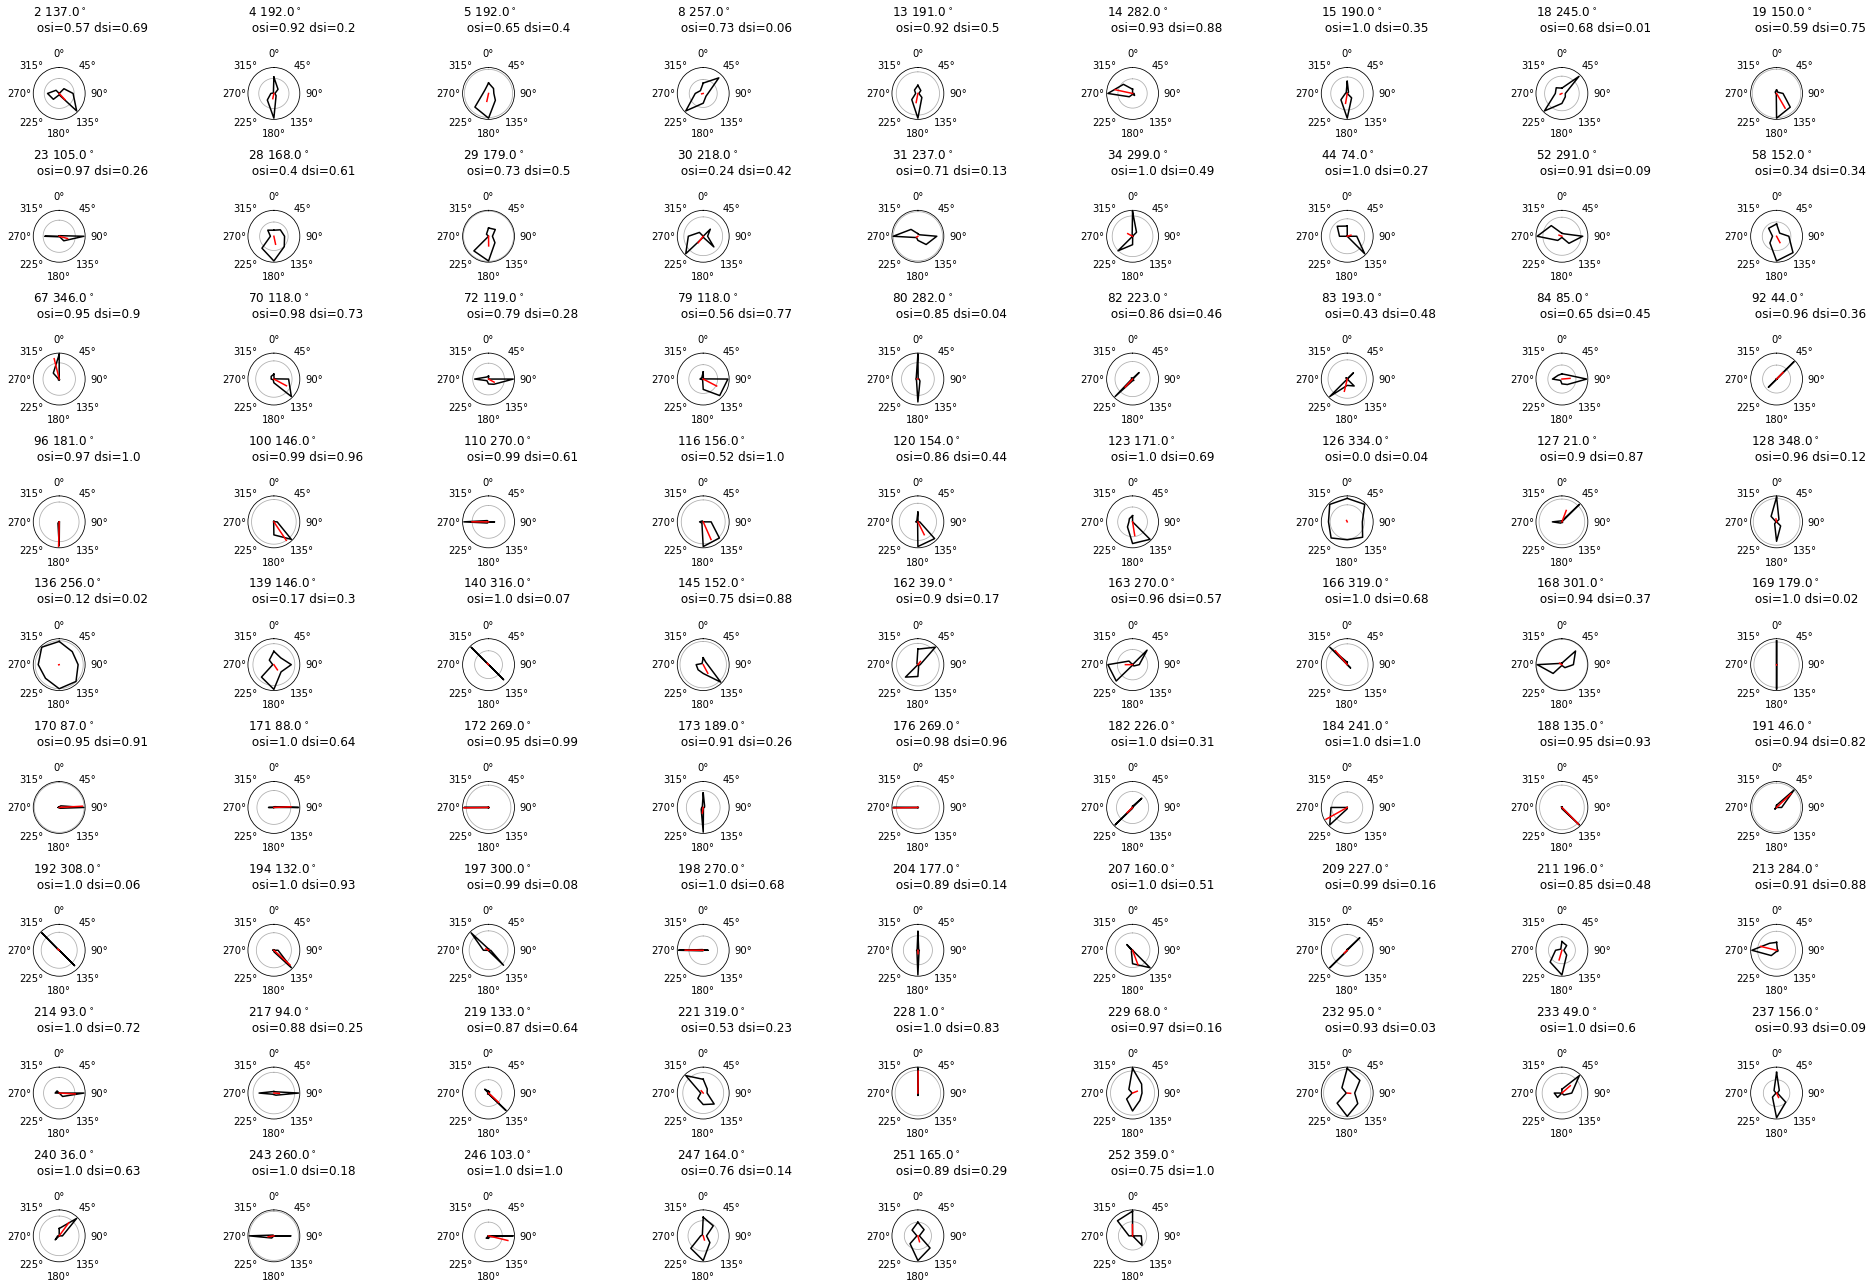

In [14]:
# USE RAW FLUORESCENCE TO COMPUTE OSI/DSI
r_anova, theta_anova = gs.make_polar_plots(gs.chosen_anova)

0.72
Fraction of Visually Responsive Neurons
 (ANOVA p < 0.01; all neurons in dataset)


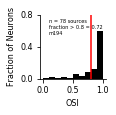

In [15]:
# THIS IS JUST THE ANOVA NEURONS FROM ALL RIGHT VISUAL AREAS
# THIS IS WHAT WE SHOW IN THE FIGURE

# Compute the fraction of neurons above this OSI threshold
clean_thresh = 0.8

anova_osis = np.array(gs.osis)[gs.chosen_anova]

frac = round(len(np.where(anova_osis > clean_thresh)[0])/len(anova_osis), 2)
print(frac)
plt.figure(figsize=(1.1811, 1.1811))

plt.hist(anova_osis, np.linspace(0, 1, 11), weights=np.ones(len(anova_osis)) / len(anova_osis), color='black')
plt.text(.1, .55, 'n = ' + str(len(anova_osis)) + ' sources\n' +
         'fraction > ' + str(clean_thresh) + ' = ' + str(frac) +
         '\n' + mouse,
         fontsize=5)
plt.ylim([0, .8])
plt.xticks([0, 0.5, 1], fontsize=8)
plt.yticks([0, 0.4, 0.8], fontsize=8)
plt.xlabel('OSI', fontsize=8)
plt.ylabel('Fraction of Neurons', fontsize=8)
plt.axvline(clean_thresh, color='r')
sns.despine()

print('Fraction of Visually Responsive Neurons\n (ANOVA p < 0.01; all neurons in dataset)')
plt.savefig('plots/2p-anova-histogram-' + mouse + '.pdf')

(array([ 2.,  5., 10., 15., 16.,  7., 12.,  8.]),
 array([-0.39269908,  0.39269908,  1.17809725,  1.96349541,  2.74889357,
         3.53429174,  4.3196899 ,  5.10508806,  5.89048623]),
 <a list of 8 Patch objects>)

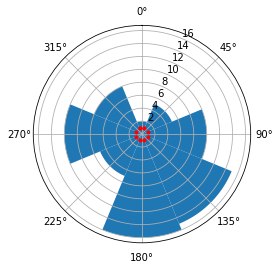

In [16]:
# Polar plot of orientation selectivity
ax = plt.subplot(1, 1, 1, polar=True)
ax.set_rorigin(0)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
dirs_r = np.deg2rad(gs.dirs)

dirs = gs.dirs
dirs = np.concatenate([dirs, np.array([360])]) - 45/2
c = np.deg2rad(dirs)# 
plt.polar(c, [1]*len(c), 'r.')

plt.hist(theta_anova, bins=c)

# state space copied below

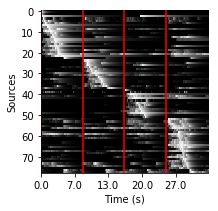

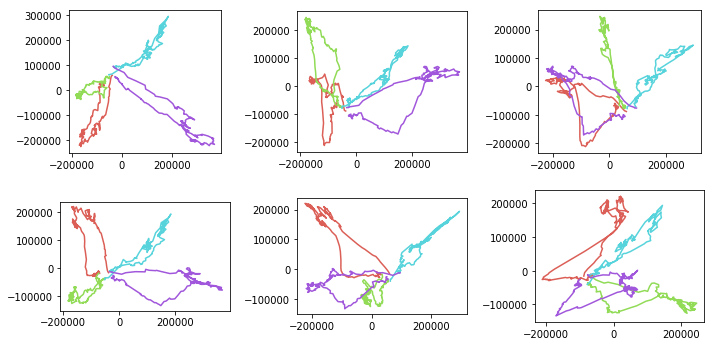

In [17]:
%matplotlib inline
gs.generate_neural_trajectories()

<IPython.core.display.Javascript object>


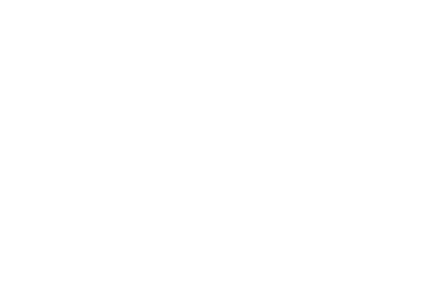

<IPython.core.display.Javascript object>


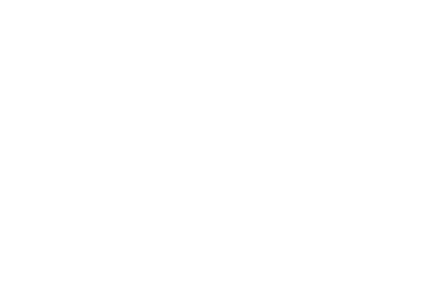

<IPython.core.display.Javascript object>


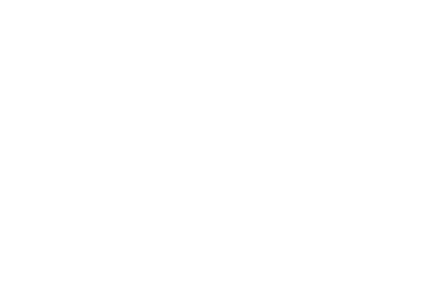

<IPython.core.display.Javascript object>


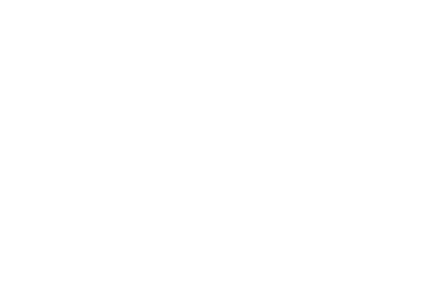

In [18]:
% matplotlib notebook
% matplotlib notebook
import matplotlib.pyplot as plt
gs.plot_neural_trajectories()

m194
1 0 74.16911459395287
2 0 103.06542227828818
2 1 94.89206259290783
3 0 88.3493682310189
3 1 91.03123653688904
3 2 83.09985864183776


<IPython.core.display.Javascript object>


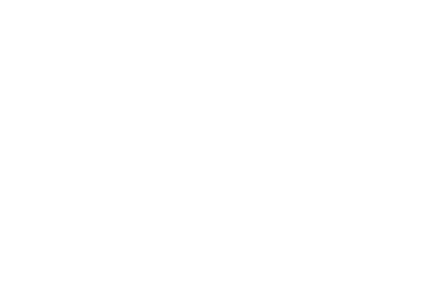

<IPython.core.display.Javascript object>


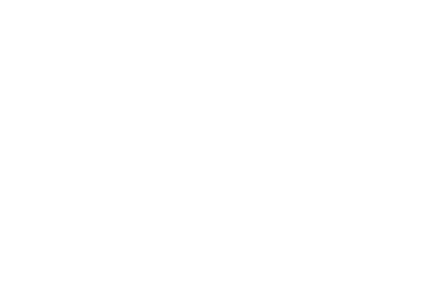

In [19]:
print(mouse)
angles = gs.compute_angles_between_trajectories()

## Model source mixing below


In [20]:
%matplotlib inline

In [8]:
# Parameters

# For random sampling
draws = 500
seeds = [11111, 22222, 33333, 44444, 55555, 66666, 77777, 88888, 99999, 101010]

# This means we'll keep simulations where p > crit_p
crit_p = 0.05

# Font size for figure
sz = 8

# Number of sources to grid search over
min_rng = np.arange(1,20,1)
max_rng = np.arange(1,50,1)

In [2]:
# COSMOS distributions
cosmos_osis = {}

# Dataset D/Mouse 12
cosmos_osis['D'] = np.array([0.35444405, 0.68697496, 0.2237449 , 0.68371413, 0.82971085,
                                0.44066118, 0.99807456, 0.46436312, 0.69556458, 0.7737553 ,
                                0.33838944, 0.48282881, 0.81126861, 0.60879963, 0.46037556,
                                0.4378772 , 0.70969237, 0.10016046, 0.61305529, 0.42675059,
                                0.61240447, 0.64597534, 0.70496208, 0.68926852, 0.71663449,
                                0.08290376, 0.55862641, 0.77170858, 0.09056974, 0.65100395,
                                0.52344037, 1.        , 0.45129034, 0.48437186, 0.40189691,
                                0.27290244, 0.80623908, 1.        , 0.75431993, 0.1973809 ,
                                0.3776872 , 1.        , 0.61011847, 0.40926305, 0.70269131,
                                0.5701994 , 0.13440267, 0.50524407, 0.73610299, 0.42683697,
                                0.29165566, 0.89988213, 0.05041853, 0.81495166, 0.39590493,
                                0.96709941, 0.08962289, 1.        ])

cosmos_osis['B'] = np.array([0.47011088, 0.56815997, 0.13726929, 0.16223052, 0.56864275,
                                0.71538789, 0.24882054, 0.64116666, 0.38837765, 0.32987855,
                                0.74064409, 0.34255319, 0.50772733, 0.31785207, 0.08801795,
                                0.30958265, 0.79132995, 0.10121885, 0.74376999, 0.34282272,
                                0.55756269, 0.63684492, 0.30740018, 0.30226362, 0.531366  ,
                                0.08960747, 0.46550802, 0.72842018, 0.46056685, 0.6979739 ,
                                0.38662218, 0.63628078, 0.50782666, 0.69307601, 0.29389363,
                                0.38050709, 0.20359776, 0.59984132, 0.52057672, 0.46013789,
                                0.25324918, 0.10168161, 0.1308172 , 0.91481339, 0.41384985,
                                0.71658435, 0.83105342, 0.34298756, 0.55472718, 0.87155052,
                                0.685129  , 0.49669165, 0.98655691, 0.92980724, 0.54346816,
                                0.71578378, 0.5968772 , 0.64311482])

cosmos_osis['A'] = np.array([0.79849698, 0.14817935, 0.91280575, 0.56793337, 0.33244861,
                                0.18885665, 0.39825527, 0.65707544, 0.31688228, 0.47346821,
                                0.73588657, 0.80883629, 0.1176002 , 1.        , 0.37228753,
                                0.34343833, 0.28597035, 0.79378837, 0.33276649, 0.45946495,
                                0.39961611, 0.54938596, 0.2540933 , 0.57694702, 0.37919147,
                                0.31271168, 0.72969956, 0.00895628, 0.79096507, 0.61786191,
                                0.44711027, 0.14780273, 0.62566871, 0.603303  , 0.3772248 ,
                                0.75092176, 0.63155281, 1.        , 0.80323264, 0.60350507,
                                0.8347738 ])

In [34]:
# Make a fake target distribution based on D (because it has the most cells)
# but with best sources (> 0.8) removed
cosmos_osis['test'] = deepcopy(cosmos_osis['D'])
cosmos_osis['test'] = cosmos_osis['test'][np.where(cosmos_osis['test'] < clean_thresh)[0]]

In [24]:
if testing == True:
    print('---------------- TESTING MODE ----------------')
    if mouse_id == 'D':
        mouse = 'test'
        mouse_id = 'test'
    else:
        raise ValueError('Test mode only applies for mouse D!')

In [6]:
def plot_osi_histogram(vals, ax=None, fontsize=7, title=''):
    if ax is None:
        ax = plt.subplot(1,1,1)

    # get fraction > 0.8
    frac = round(len(np.where(vals > clean_thresh)[0])/len(vals), 2)
    print(frac)

    with plt.rc_context({'font.size': fontsize}):
        ax.hist(vals,
                 np.linspace(0, 1, 11),
                 weights=np.ones(len(vals)) / len(vals), color='black')
        ax.set_ylim([0, .8])
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.4, 0.8])
        ax.set_xlabel('OSI')
        ax.set_ylabel('Fraction of Neurons')
        ax.axvline(clean_thresh, color='r')
        ax.set_title(title)
        ax.text(.3, .7, str(frac*100) + '%', fontsize=12)
        sns.despine()

def mixed_source_model(cat_fields, kept_cells, mix=True, n_draws=1000,
                       dt=1/30, mixture_range=[1, 5], seed=55555):

    # Fix seed for reproducibility
    np.random.seed(seed)

    # This is the list of all valid sources
    kept = np.where(kept_cells == 1)[0]
    
    # Spikes is filled with dummy variables because we will not use it
    spikes = np.concatenate([np.array(m.todense()) for m in cat_fields['S']])
    spikes *= 0
    spikes += 1

    if mix:
        # Get the number of sources that will be mixed into each new source
        mixture_sizes = np.random.randint(mixture_range[0],
                                          mixture_range[1], n_draws)

        # Choose the sources + weights that will be mixed for each source
        new_fields = deepcopy(cat_fields)
        for key in ['C', 'C_raw']:
            new_field = []
            for dx in range(n_draws):
                sz = mixture_sizes[dx]
                mixture_idx = kept[np.random.randint(0, len(kept), sz)]
                mixture_weights = np.ones(sz) / sz
                new_field.append(np.dot(mixture_weights, cat_fields[key][mixture_idx, :]))
            new_fields[key] = np.array(new_field)
        cat_traces = TwoPhotonTraces(new_fields['C'], new_fields['C_raw'],
                                     spikes, dt, led_frames, mouse_id)
    else:
        # Resample with replacement
        draws = kept[np.random.randint(0, len(kept), n_draws)]
        cat_traces = TwoPhotonTraces(cat_fields['C'][draws, :], cat_fields['C_raw'][draws, :],
                                     spikes, dt, led_frames, mouse_id)

    # Compute osis
    gr = utils.GratingStimulus(cat_traces, is_cosmos, make_plot=False, osi_thresh=.65, use_filtered='F')
    chosen_osis = np.array(gr.osis)[gr.chosen_anova]
    
    # Histogram-binned OSIs
    binned_osis = np.histogram(chosen_osis, np.linspace(0, 1, 11))[0]
    
    return chosen_osis, binned_osis

In [26]:
# We want to make the mixed histogram resemble this COSMOS histogram
hist_cosmos = np.array(np.histogram(cosmos_osis[mouse_id], np.linspace(0, 1, 11))[0], dtype=float)
hist_cosmos[np.where(hist_cosmos == 0)[0]] = 1e-5

kl_means = np.zeros((len(min_rng), len(max_rng)))
kl_sem = np.zeros((len(min_rng), len(max_rng)))
kl_vals = np.zeros((len(min_rng), len(max_rng), len(seeds)))
for idx, min_v in enumerate(min_rng):
    print(min_v)
    for jdx, max_v in enumerate(max_rng):
        if min_v >= max_v:
            # If we don't compute anything, set the value to nan
            kl_vals[idx, jdx] = np.nan
            continue

        for sx, seed in enumerate(seeds):
            # Save the valid KL divergences
            osis_mixed, hist_mixed = mixed_source_model(cat_fields, kept_cells, mix=True,
                                                        mixture_range=[min_v, max_v],
                                                        n_draws=draws, seed=seed)

            # Use reverse KL
            # https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/
            kl_vals[idx, jdx, sx] = stats.entropy(hist_mixed, hist_cosmos)
        kl_means[idx, jdx] = np.mean(kl_vals[idx, jdx, :])
        kl_sem[idx, jdx] = stats.sem(kl_vals[idx, jdx, :])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [27]:
# Replace zeros with nan
r, c = np.where(kl_means == 0)
kl_means[r, c] = np.nan

In [28]:
mouse

'm194'

2 10 1.0
4 7 0.4176355610785011
2 9 0.4680965455429503
4 6 0.26883149681850316
3 7 0.306815795464054
4 8 0.09260988264560875
3 8 0.18384370066996641
2 7 0.0500061284790661
3 9 0.09933600312696264
2 8 0.059508709496349926
1 15 0.05844548085885939
1 12 0.05267349850999131


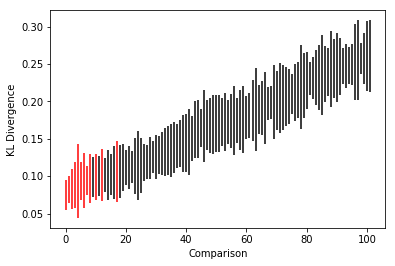

In [29]:
# Determine which simulations are insignificantly different from the minimum one
r_min, c_min = np.unravel_index(np.argsort(kl_means, axis=None)[0], kl_means.shape)
kl_min = kl_vals[r_min, c_min]

equiv_map = np.zeros(np.shape(kl_means))
for x, v in enumerate(np.argsort(kl_means, axis=None)):
    r, c = np.unravel_index(v, kl_means.shape)
    sem = kl_sem[r, c]
    sd = np.std(kl_vals[r, c, :])
    p = stats.ttest_ind(kl_vals[r, c, :], kl_min).pvalue
    # The insigificant P values are where we cant say there's a difference
    color = 'k'
    if p > crit_p:
        print(min_rng[r], max_rng[c], p)
        equiv_map[r, c] = 1
        color = 'r'
    plt.errorbar(x, kl_means[r, c], yerr=sd, color=color)
    if x > 100:
        break
plt.ylabel('KL Divergence')
plt.xlabel('Comparison')
plt.savefig('plots/' + mouse + 'significant_pairs.pdf')

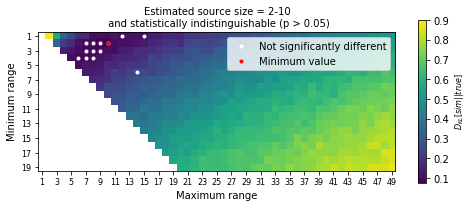

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8, 3))
v = ax.imshow(kl_means, aspect='equal')
ax.set_xticks(np.arange(len(max_rng))[::2])
ax.set_xticklabels(max_rng.tolist()[::2], fontsize=sz)
plt.xlabel('Maximum range', fontsize=sz+2)
#v.set_clim(0, 3)

cbar = plt.colorbar(ax.get_children()[9])
cbar.set_label('$D_{KL}[sim || true]$', fontsize=sz)

ax.set_yticks(np.arange(len(min_rng))[::2])
_ = ax.set_yticklabels(min_rng.tolist()[::2], fontsize=sz)
plt.ylabel('Minimum range', fontsize=sz+2)


plt.title('Estimated source size = ' + str(min_rng[r_min]) + '-' + str(max_rng[c_min]) +
          '\n and statistically indistinguishable (p > ' + str(crit_p) + ')', fontsize=sz+2)
ra, ca = np.where(equiv_map == 1)
plt.plot(c, r, 'w.', label='Not significantly different')
for r, c in zip(ra, ca):
    plt.plot(c, r, 'w.')
plt.plot(c_min, r_min, 'r.', label='Minimum value')
plt.legend()
plt.savefig('plots/' + mouse + 'range_map.pdf')

0.7
0.16
0.19


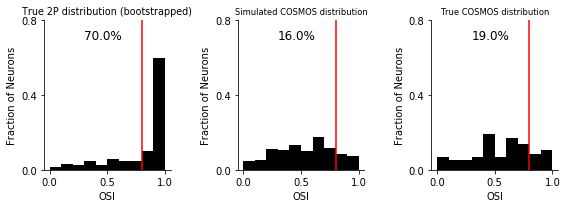

In [31]:
fig, ax = plt.subplots(1,3, figsize=(8, 3))

# Plot the true 2P distribution
rng = [min_rng[r_min], max_rng[c_min]]
osis_pure, hist_pure = mixed_source_model(cat_fields, kept_cells, mix=False,
                                          mixture_range=rng,
                                          n_draws=draws, seed=55555)
plot_osi_histogram(osis_pure, ax[0], sz, title='True 2P distribution (bootstrapped)')


# Plot an example of our estimate vs. the true cosmos distribution
osis_mixed, hist_mixed = mixed_source_model(cat_fields, kept_cells, mix=True,
                                                    mixture_range=rng,
                                                    n_draws=draws, seed=55555)
plot_osi_histogram(osis_mixed, ax[1], title='Simulated COSMOS distribution')
        
# Plot the true COSMOS distribution
plot_osi_histogram(cosmos_osis[mouse_id], ax[2], title='True COSMOS distribution')

plt.tight_layout()
plt.savefig('plots/' + mouse + 'histograms.pdf')

In [ ]:
# Compare control OSI distributions to COSMOS datasets

In [18]:
cosmos_osis['c1'] = np.array([0.27422012, 0.37548586, 0.5053033 , 0.45152629, 0.4281676 ,
                     0.73110139])
cosmos_osis['c2'] = np.array([0.22305112, 0.50744074, 0.58207469, 0.54930757, 0.62867936,
                     0.44993747, 0.50523345, 0.64768525, 0.15608783, 0.23431211,
                     0.34415885, 0.09921343, 0.45894629, 0.59066105, 0.59110892,
                     0.33349897, 0.55848591, 0.01673939, 0.79414751, 0.32474501,
                     0.19899731, 0.04555889, 0.28343115, 0.1197383 , 0.48611398,
                     0.0624511 , 0.35851372, 0.21811405, 0.5854334 , 0.22984644,
                     0.15276303])

In [35]:
# get length of each osi vector
len(cosmos_osis['test'])

47

In [36]:
# get mean osi for each group
np.mean(cosmos_osis['test'])

0.4768289319148937

In [20]:
# LUT for significance stars
def get_stars(p_value):
    """ Take in a p-value and return stars. """
    star_map=[('ns', np.inf), ('*', 0.05),
              ('**', 0.01), ('***', 0.001),
              ('****', 0.0001)]
    if np.isinf(p_value) or np.isnan(p_value):
        return 'ns'

    for label, thresh in star_map[::-1]:
        if p_value < thresh:
            return label

In [28]:
# so D, B, A are all different from c2, but not c1 because c1 has too few sources 
bonferroni_correct = 3 # control vs. D, B, A
for xdx, x in enumerate(cosmos_osis.keys()):
    for ydx, y in enumerate(cosmos_osis.keys()):
        if x != y and y in ['c1', 'c2'] and xdx < ydx and x not in ['c1', 'c2']:
            p = stats.mannwhitneyu(cosmos_osis[x],
                                   cosmos_osis[y],
                                   alternative='two-sided').pvalue
            print(x, y, p * bonferroni_correct, get_stars(p * bonferroni_correct))

D c1 0.9159887114195386 ns
D c2 0.0026198864996285513 **
B c1 1.9104168338852778 ns
B c2 0.044957061679469335 *
A c1 1.6660234918803007 ns
A c2 0.028546676932332198 *
